In [1]:
#pip install dataprep

In [4]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [6]:
# Import Dataset
df = pd.read_excel("Airlines+Data.xlsx")
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (96, 2)


Month  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121
5 1995-06-01         135
6 1995-07-01         148
7 1995-08-01         148
8 1995-09-01         136
9 1995-10-01         119

[Table of Contents](#0.1)

## 3. Data Exploration <a class="anchor" id="3"></a>

Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

In [7]:
df.isnull().any()

Month         False
Passengers    False
dtype: bool

In [8]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

<Axes: >

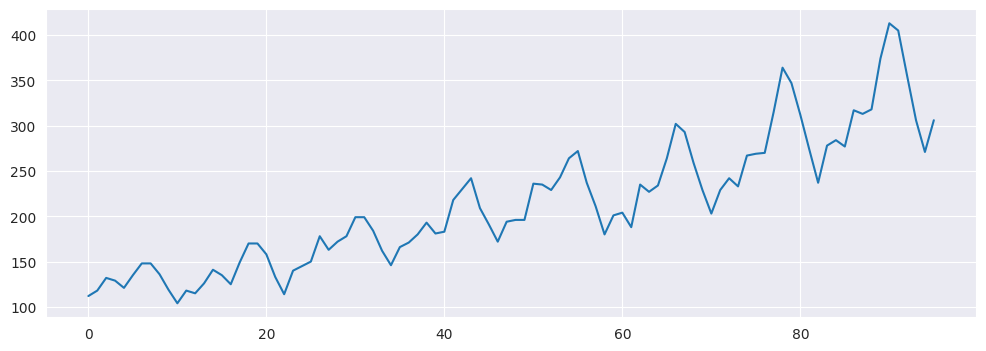

In [9]:
df.Passengers.plot(figsize=(12,4))

- We have no missing data so all the entries are valid for use.

- Now we can check the column names to get a better understanding of what features we will be basing our regression on.

### 3.1 Descriptive Analysis<a class="anchor" id="3.1"></a>

In [10]:
df.shape

(96, 2)

In [11]:
#Checking the data types
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [12]:
#Unique values for every feature
df.nunique()

Month         96
Passengers    80
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [14]:
df[df.duplicated()].shape

(0, 2)

In [15]:
df[df.duplicated()]

Empty DataFrame
Columns: [Month, Passengers]
Index: []

In [16]:
df.describe()

Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

### Feature Engineering

#### Renaming the Month column into Date

In [17]:
df.rename({'Month':'Date'},axis=1, inplace=True)

#### Making the Date as DateTime index for the Dataframe

In [18]:
df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [19]:
df1.head()

Passengers
Date                  
1995-01-01         112
1995-02-01         118
1995-03-01         132
1995-04-01         129
1995-05-01         121

#### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [20]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

Date  Passengers month  year
0 1995-01-01         112   Jan  1995
1 1995-02-01         118   Feb  1995
2 1995-03-01         132   Mar  1995
3 1995-04-01         129   Apr  1995
4 1995-05-01         121   May  1995
5 1995-06-01         135   Jun  1995
6 1995-07-01         148   Jul  1995
7 1995-08-01         148   Aug  1995
8 1995-09-01         136   Sep  1995
9 1995-10-01         119   Oct  1995

### Data Visualization

<Axes: xlabel='month', ylabel='year'>

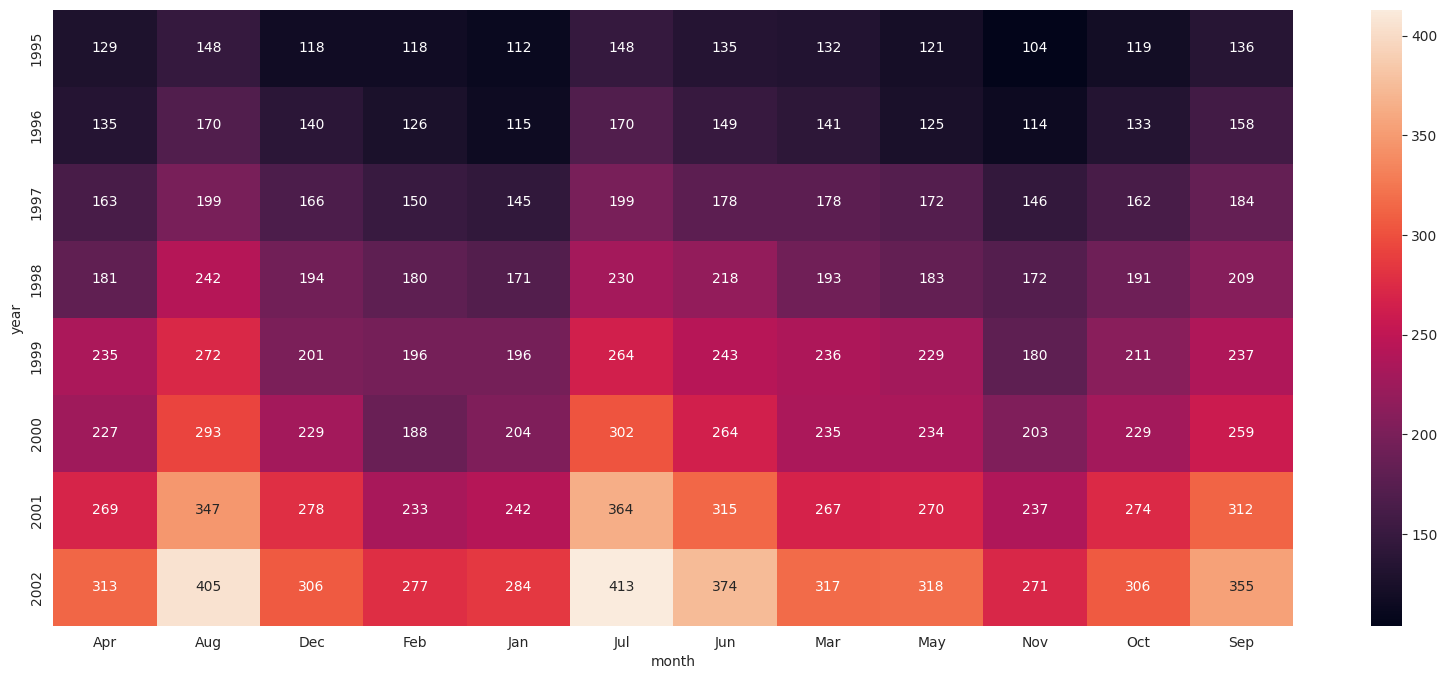

In [21]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

#### Line plot

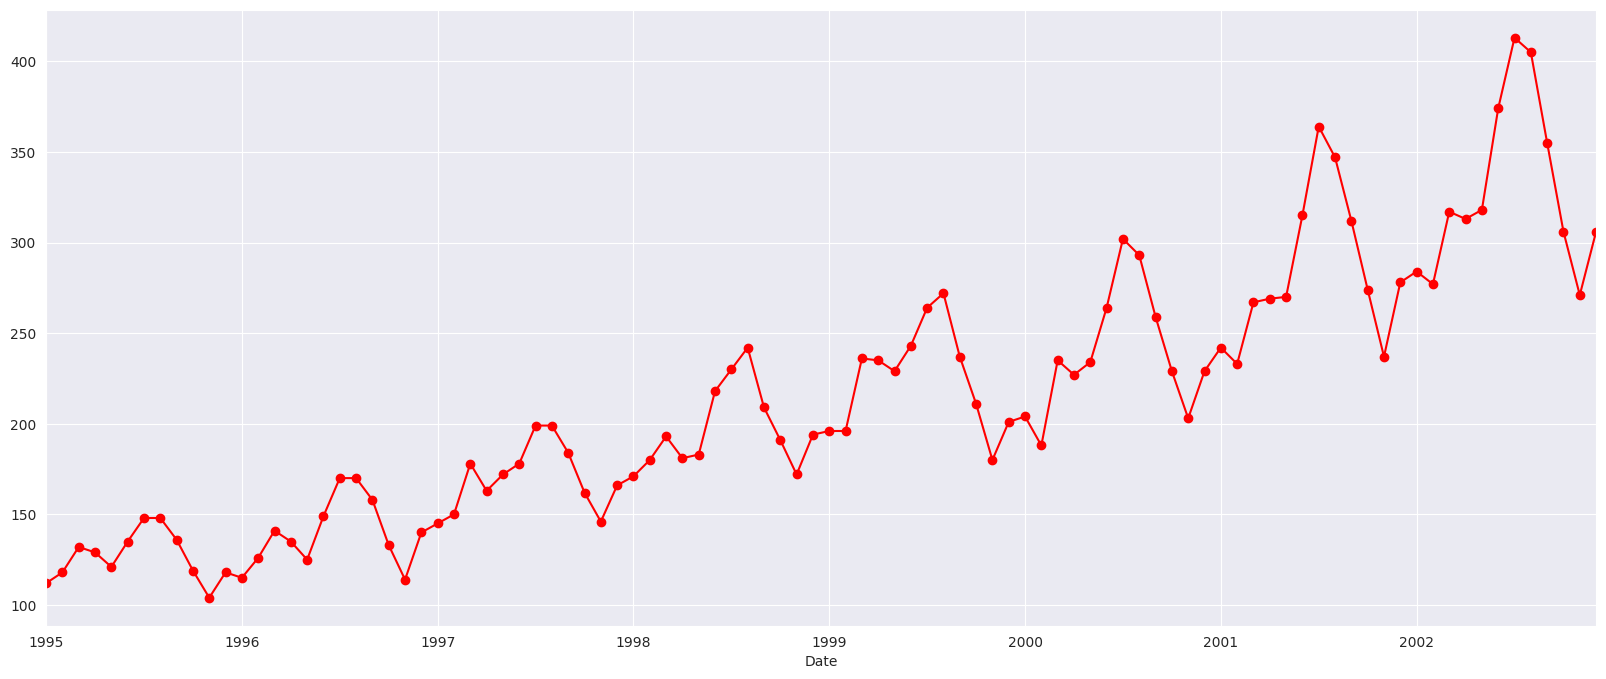

In [22]:
df1['Passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

##### Observation:^
1. We can see that there is an increasing Trend. So, Trend is not constant.
2. Variance is also not constant.

Hence the time serise is not stationary.

#### Yearly Passenger Analysis

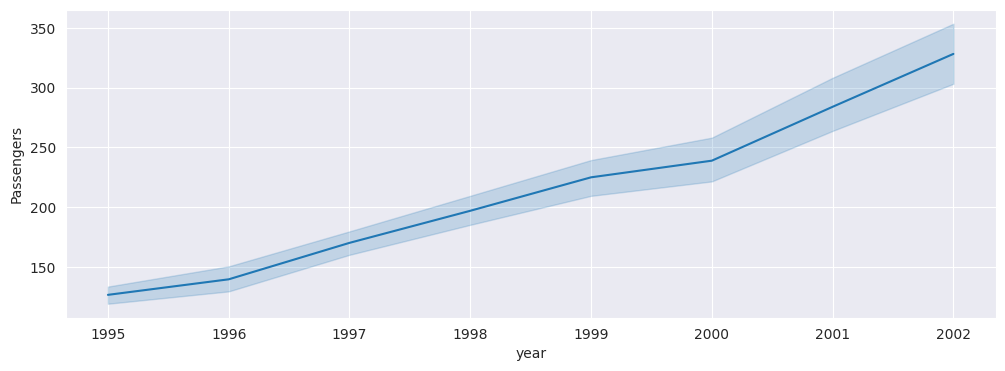

In [23]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Passengers",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

#### Box Plot of Each Year by Monthly Intervals

<Axes: xlabel='year', ylabel='Passengers'>

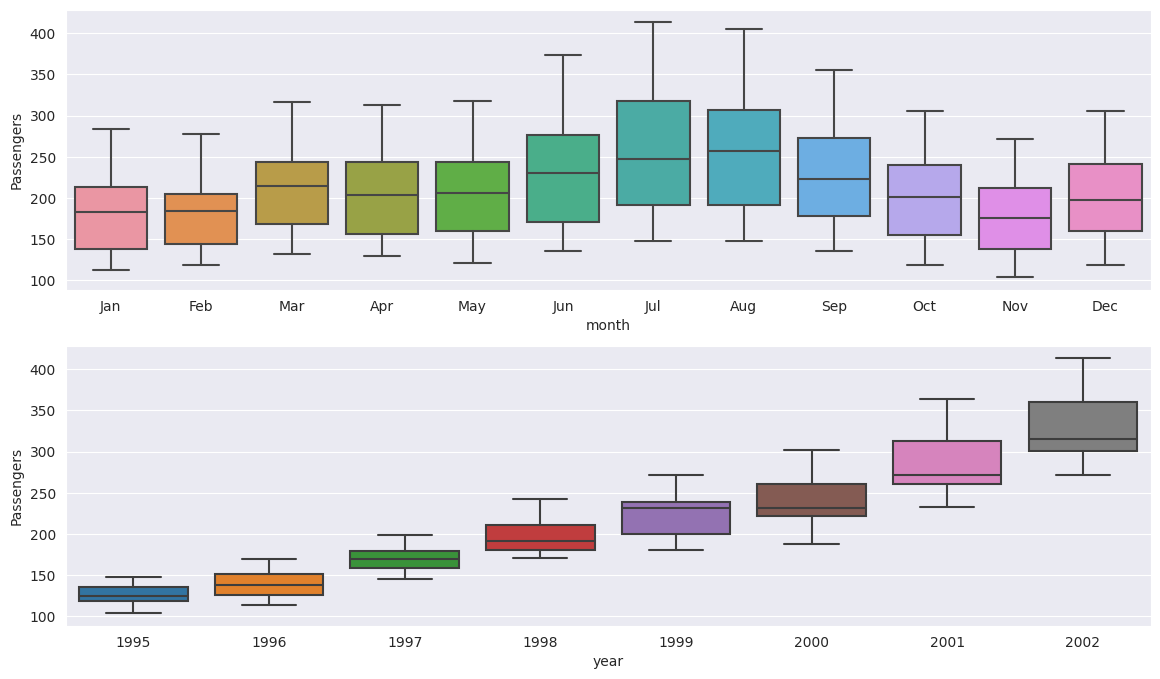

In [24]:
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=df)

#### Histogram and Density Plots

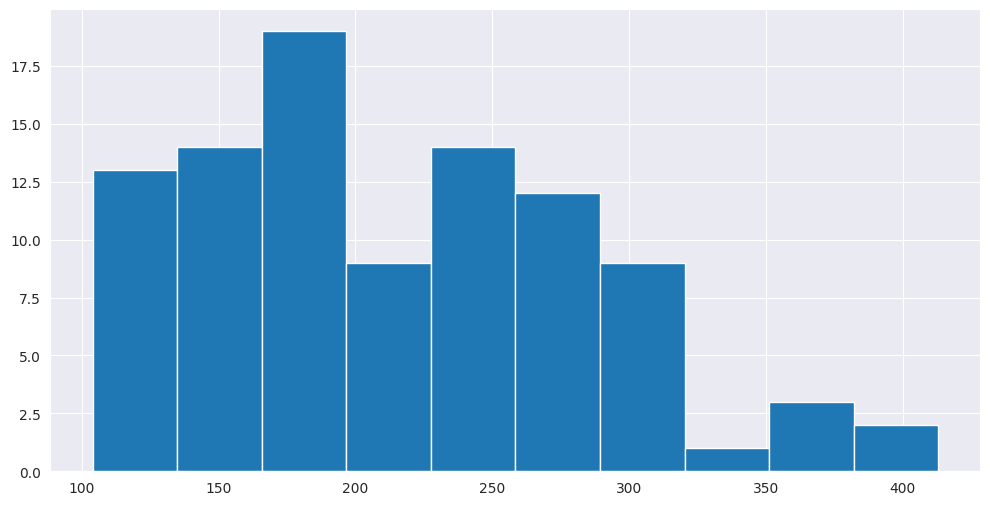

In [25]:
df.Passengers.hist(figsize=(12,6))
plt.show()

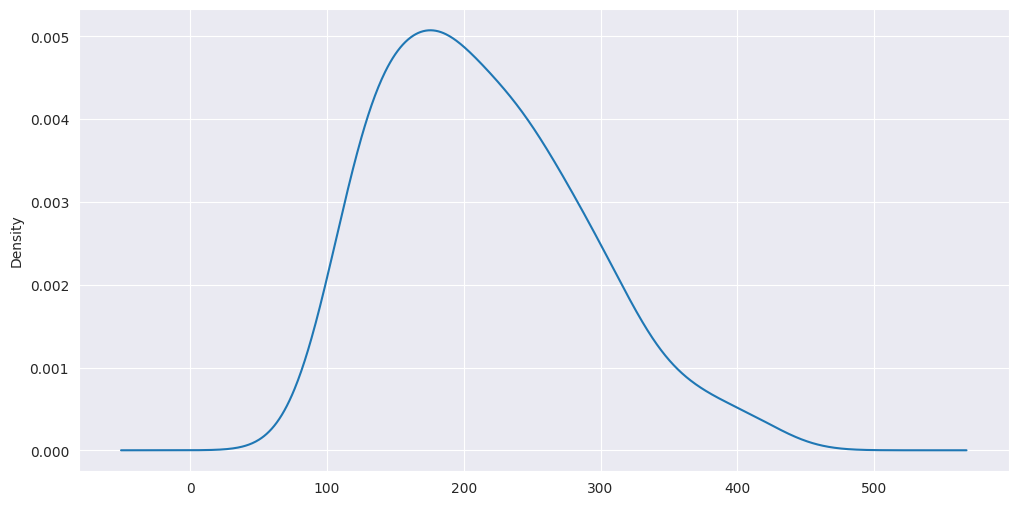

In [26]:
# create a density plot
df.Passengers.plot(kind='kde', figsize=(12,6))
plt.show()

#### Lag plot

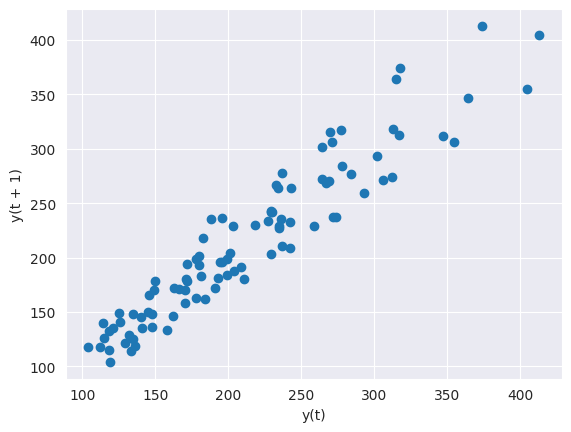

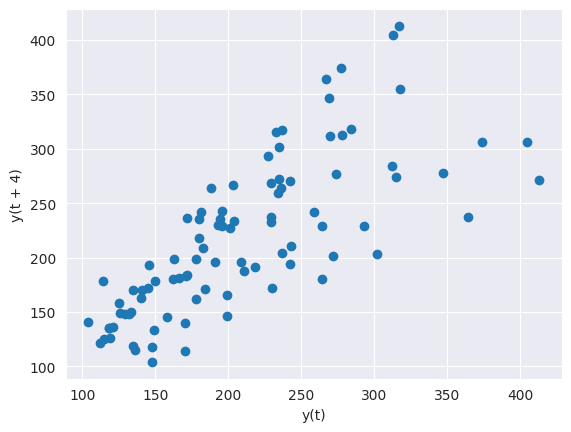

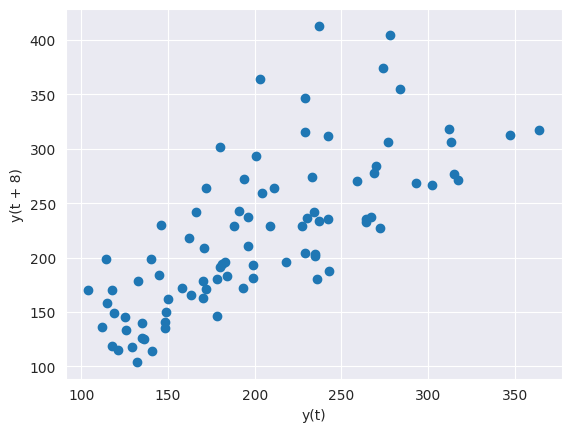

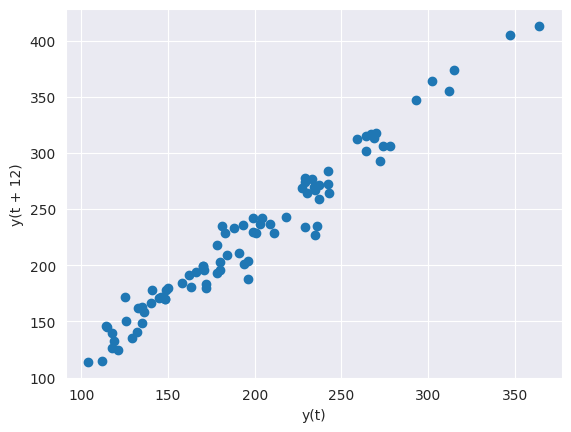

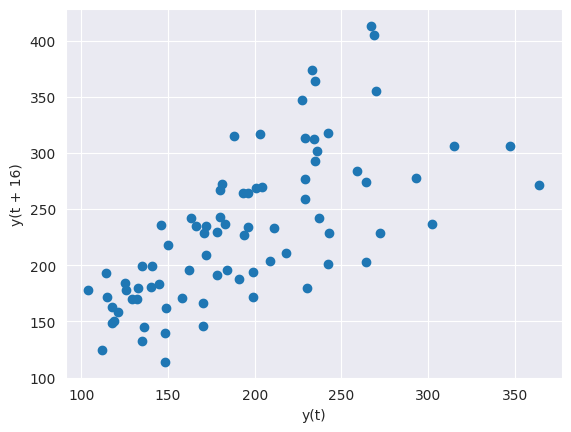

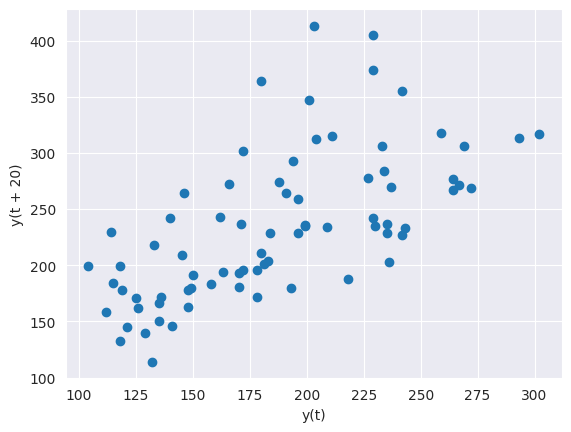

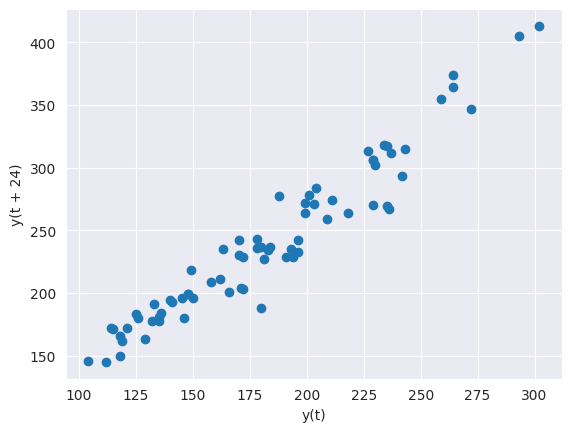

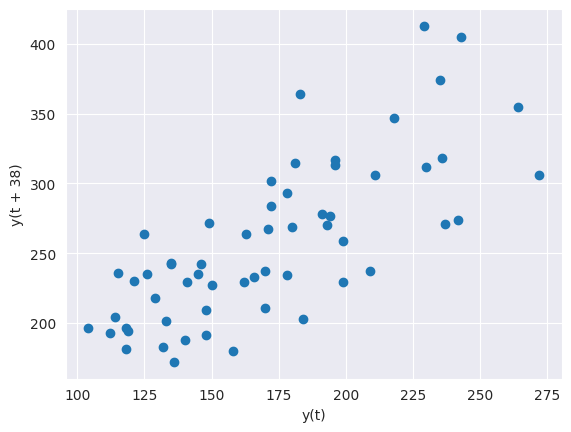

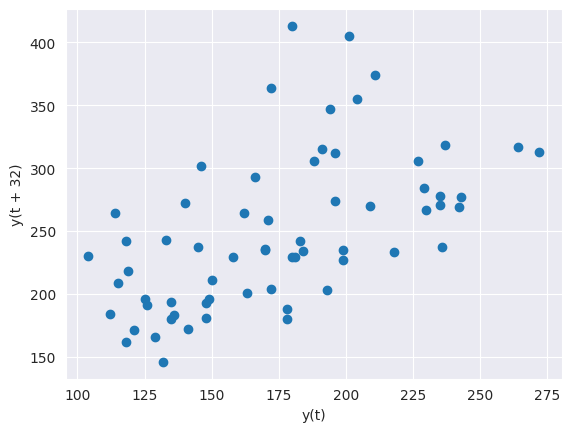

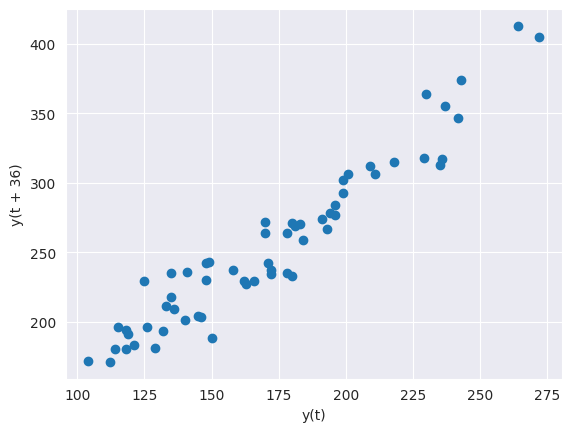

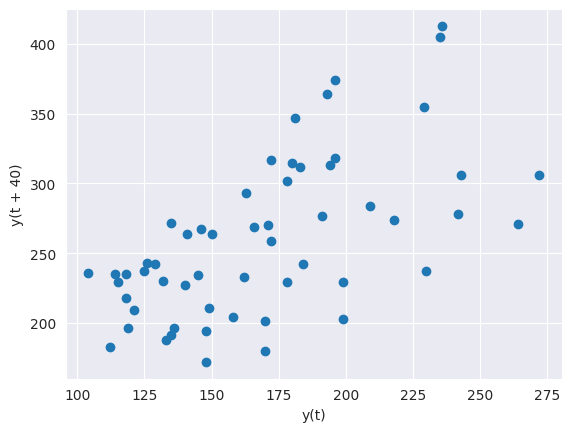

In [27]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

### Moving Average

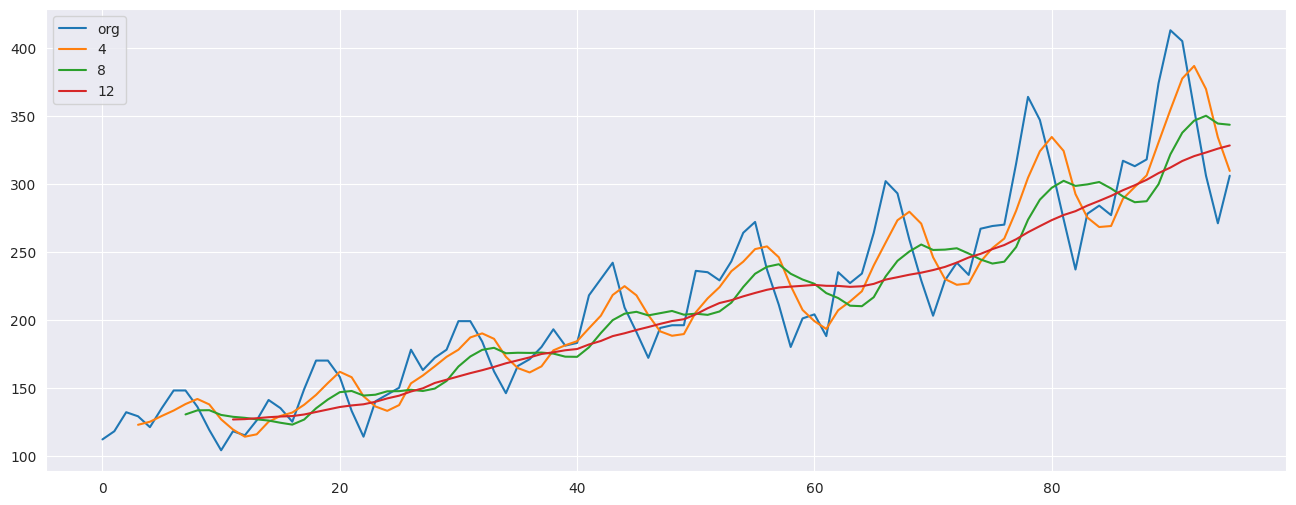

In [28]:
plt.figure(figsize=(16,6))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

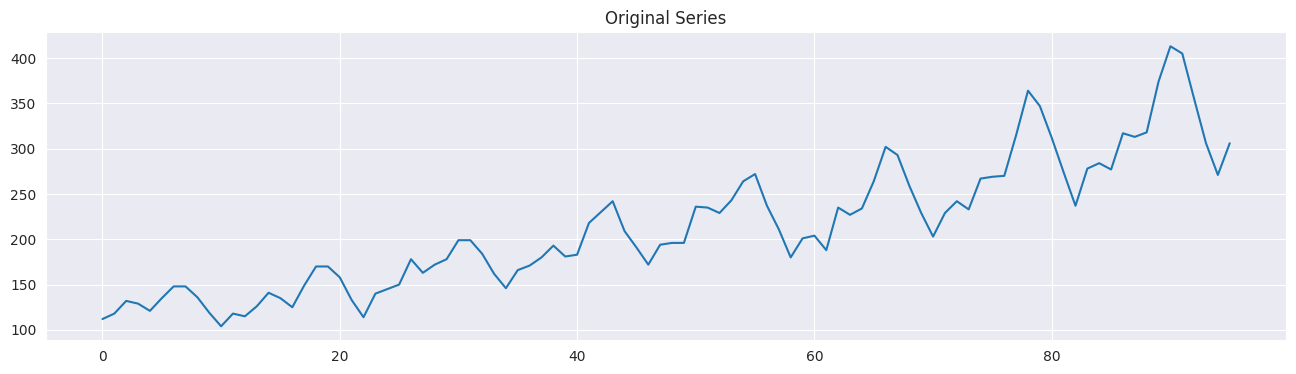

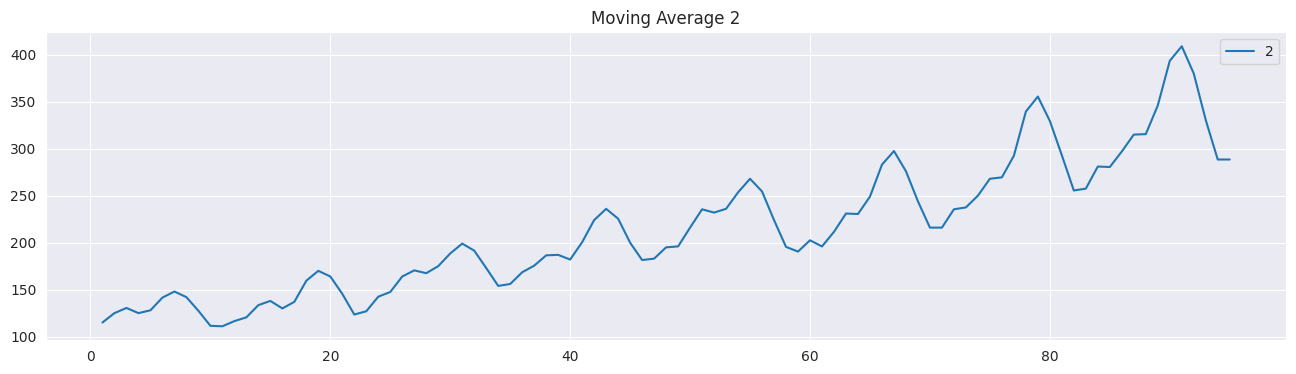

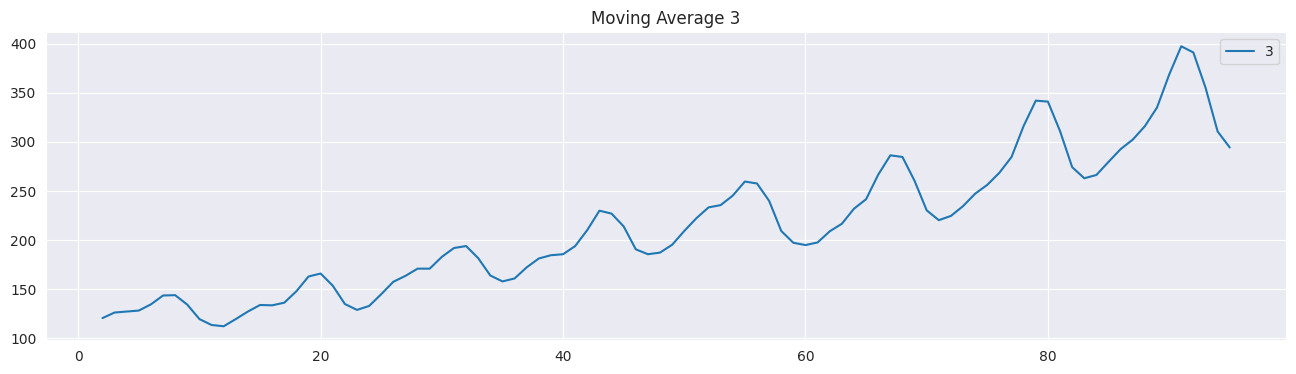

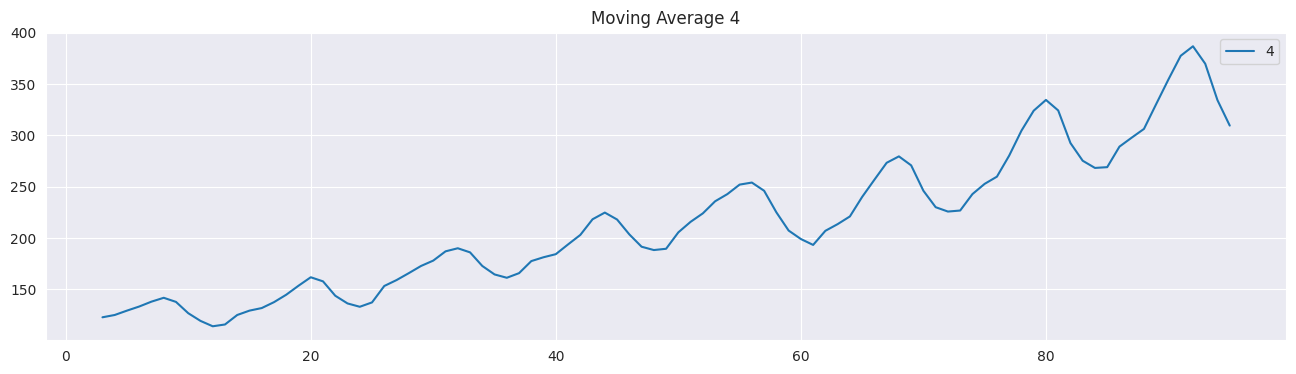

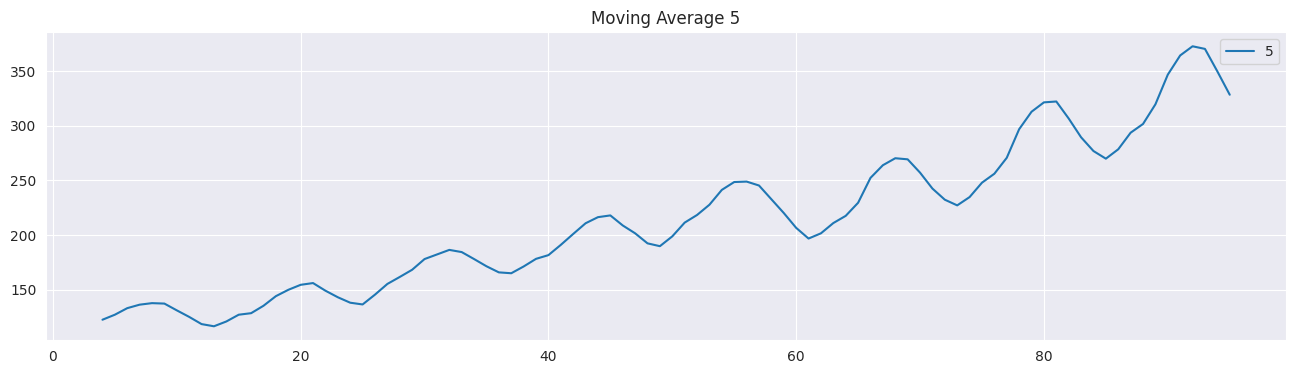

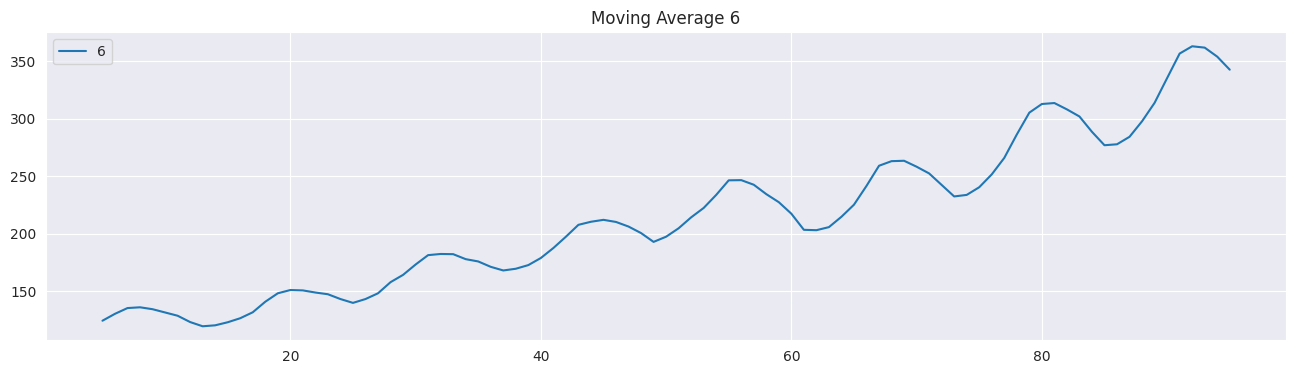

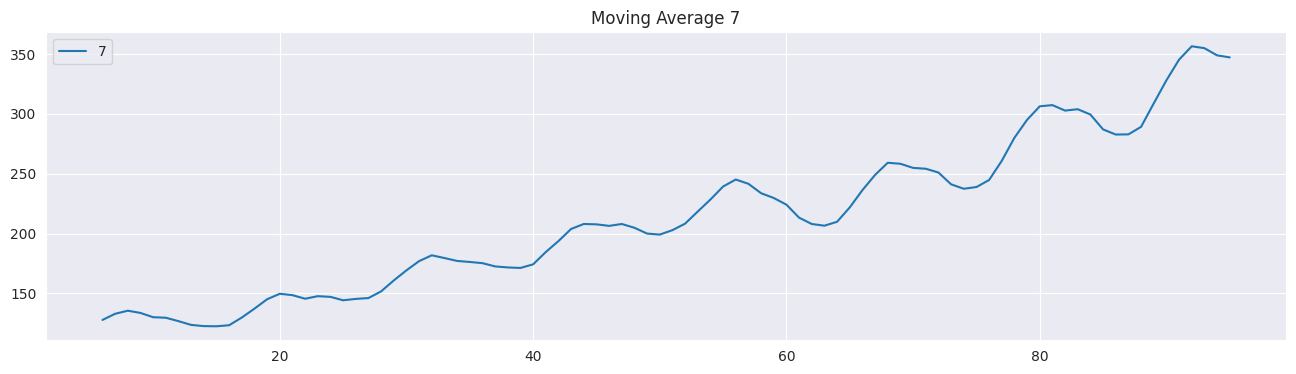

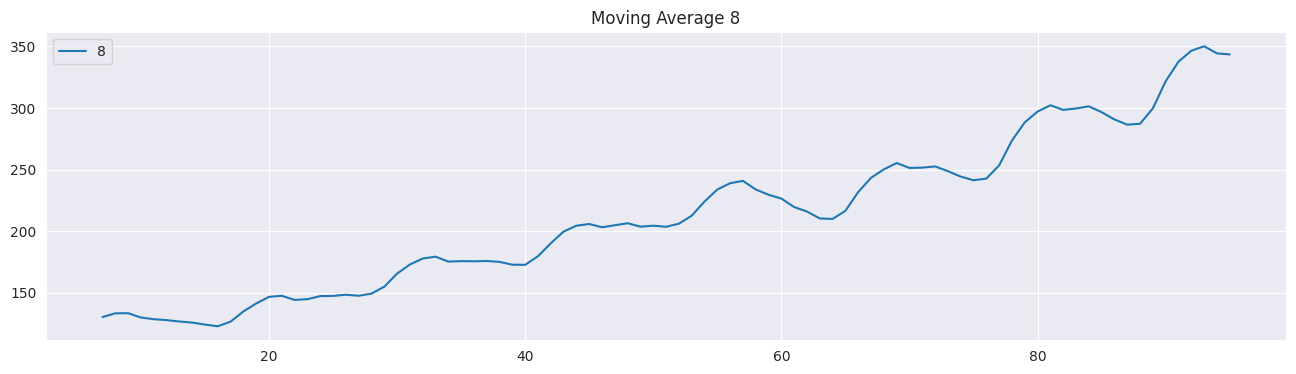

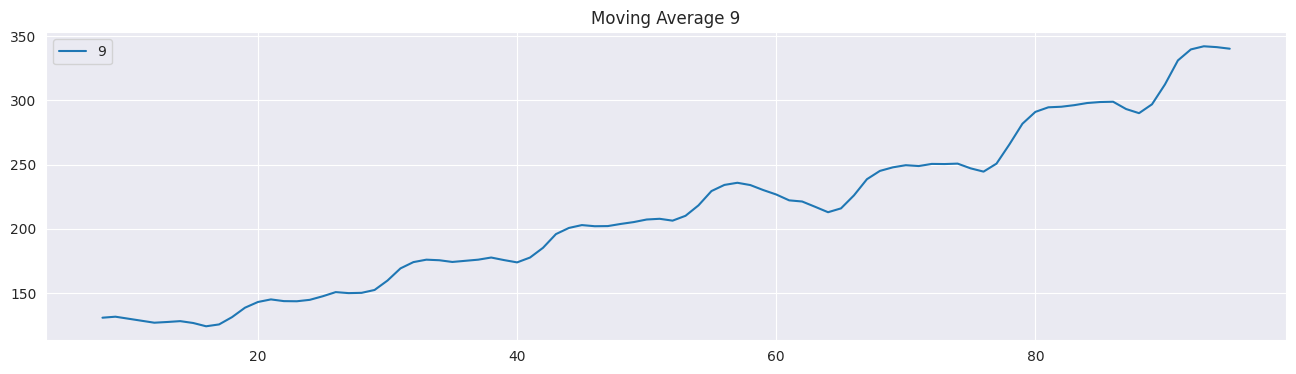

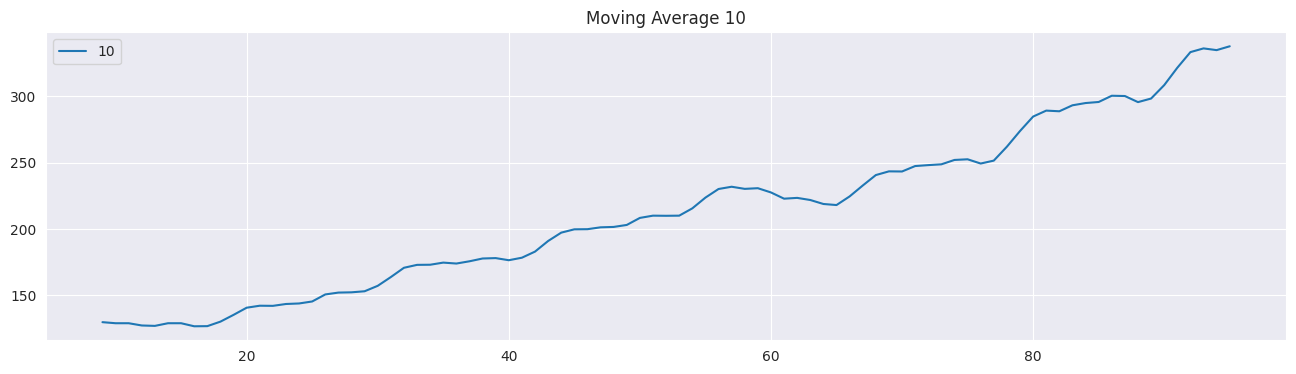

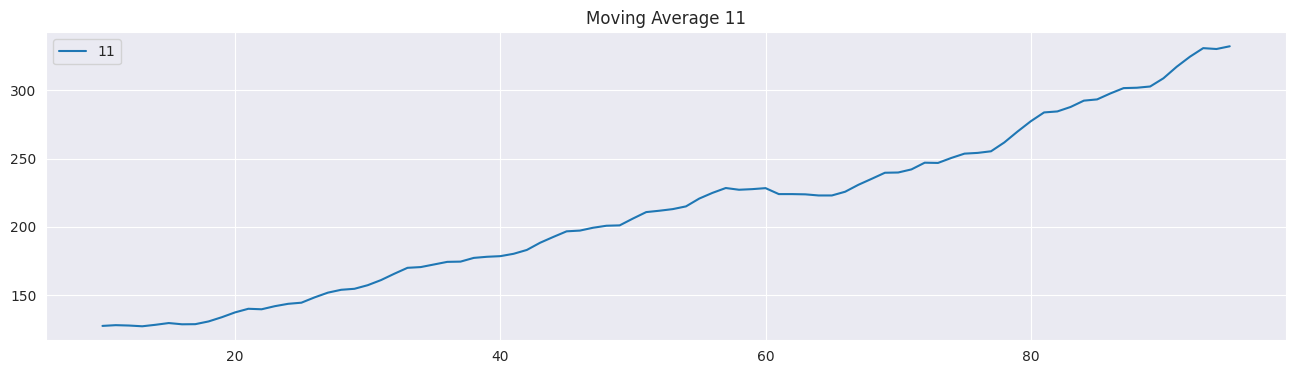

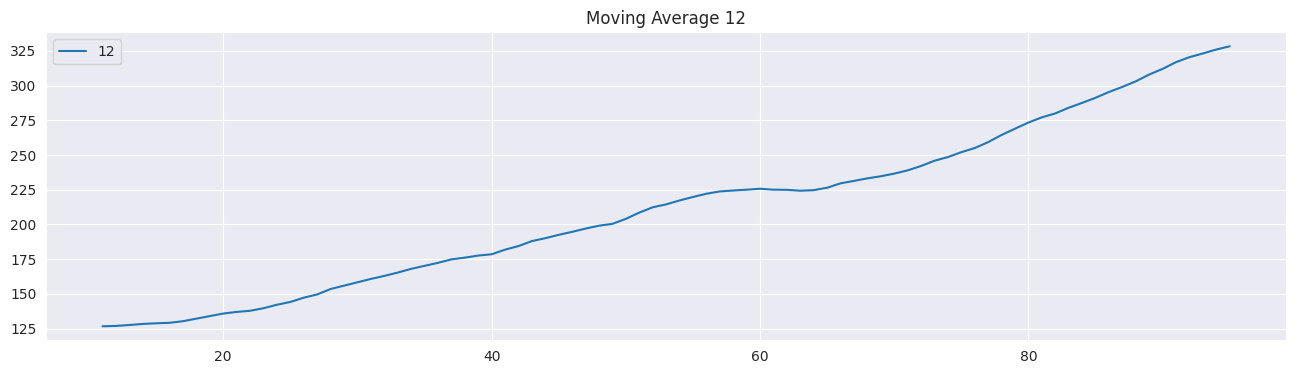

In [29]:
plt.figure(figsize=(16,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

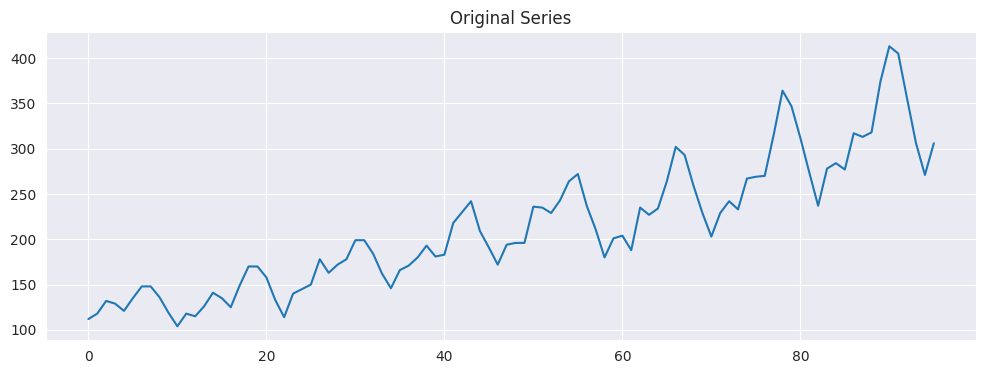

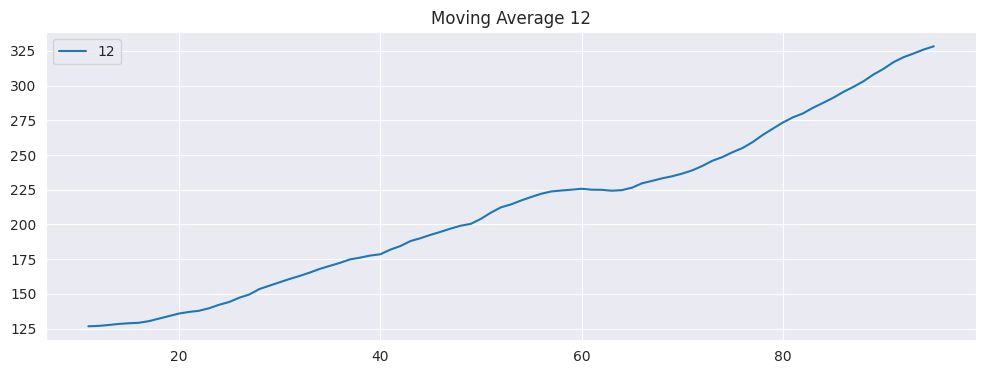

In [30]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

### Time series decomposition plot

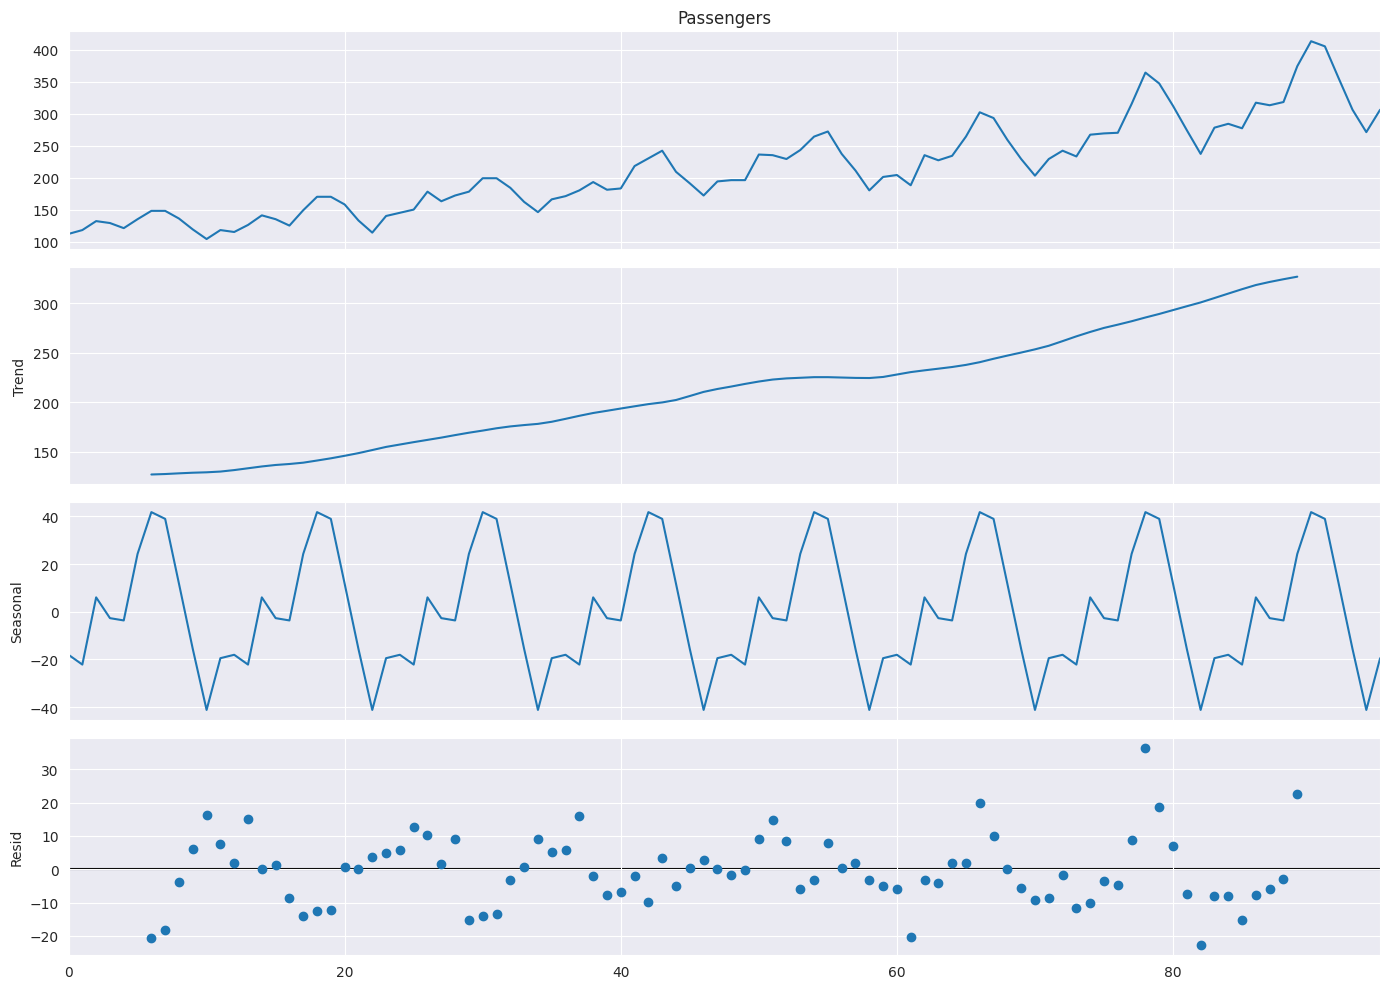

In [31]:
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

### ACF plots and PACF plots

#### Autocorrelation Function (ACF)
The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units. A lag corresponds to a certain point in time after which we observe the first value in the time series.

The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). A coefficient of 0 means that there is no relationship between the variables. Also, most often, it is measured either by Pearson’s correlation coefficient or by Spearman’s rank correlation coefficient.

It’s most often used to analyze sequences of numbers from random processes, such as economic or scientific measurements. It can also be used to detect systematic patterns in correlated data sets such as securities prices or climate measurements. Usually, we can calculate the ACF using statistical packages from Python and R or using software such as Excel and SPSS. Below, we can see an example of the ACF plot:

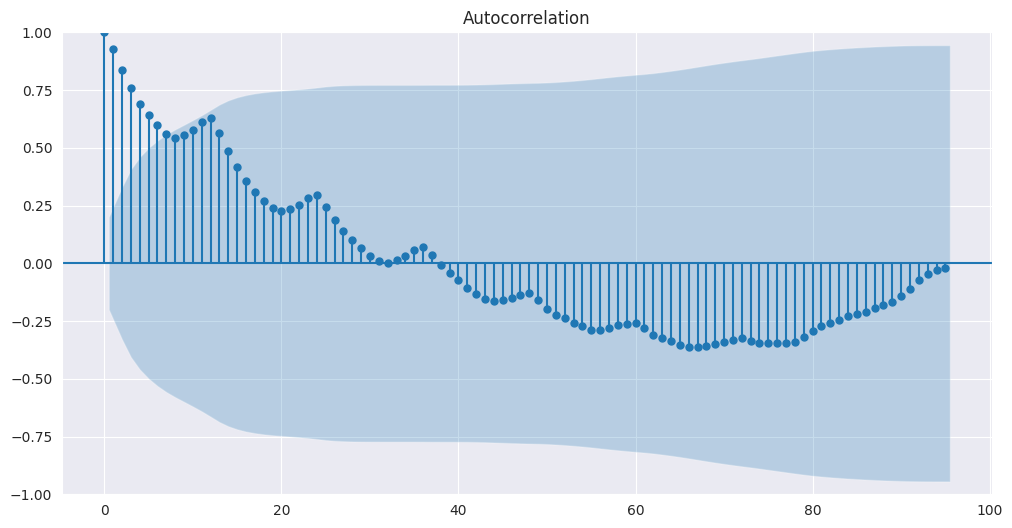

In [32]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()

Blue bars on an ACF plot above are the error bands, and anything within these bars is not statistically significant. It means that correlation values outside of this area are very likely a correlation and not a statistical fluke. The confidence interval is set to 95% by default.

Notice that for a lag zero, ACF is always equal to one, which makes sense because the signal is always perfectly correlated with itself.

#### To summarize, autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation

#### Partial Autocorrelation Function (PACF)
Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables. For example, if we’re regressing a signal S at lag t (S_{t}) with the same signal at lags t-1, t-2 and t-3 (S_{t-1}, S_{t-2}, S_{t-3}), the partial correlation between S_{t} and S_{t-3} is the amount of correlation between S_{t} and S_{t-3} that isn’t explained by their mutual correlations with S_{t-1} and S_{t-2}.

That being said, the way of finding PACF between S_{t} and S_{t-3} is to use regression model

(1) \begin{align*} S_{t} = \phi_{1}S_{t-1} + \phi_{2}S_{t-2} + \phi_{3}S_{t-3} + \epsilon \end{align*}

where  \phi_{1}, \phi_{2} and \phi_{3} are coefficients and \epsilon is error. From the regression formula above, the PACF value between S_{t} and S_{t-3} is the coefficient \pi_{3}. This coefficient will give us direct effect of time-series S_{t-3} to the time-series S_{t} because the effects of S_{t-2} and S_{t-1} are already captured by \phi_{1} and \phi_{2}.

The figure below presents the PACF plot:

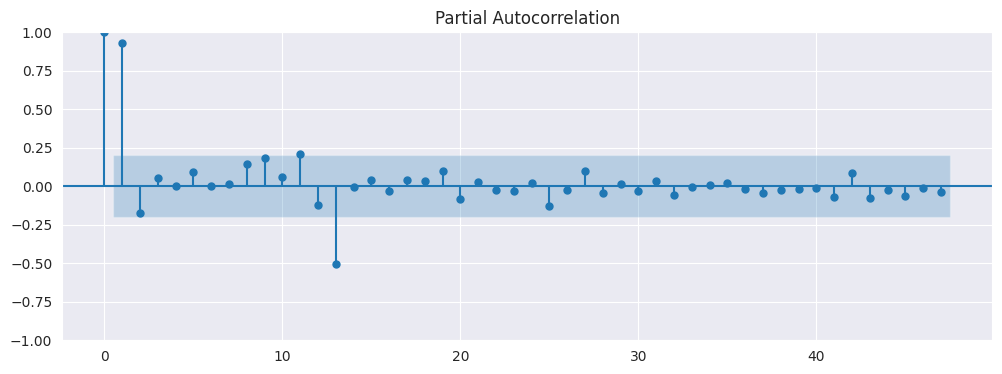

In [33]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

#### To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

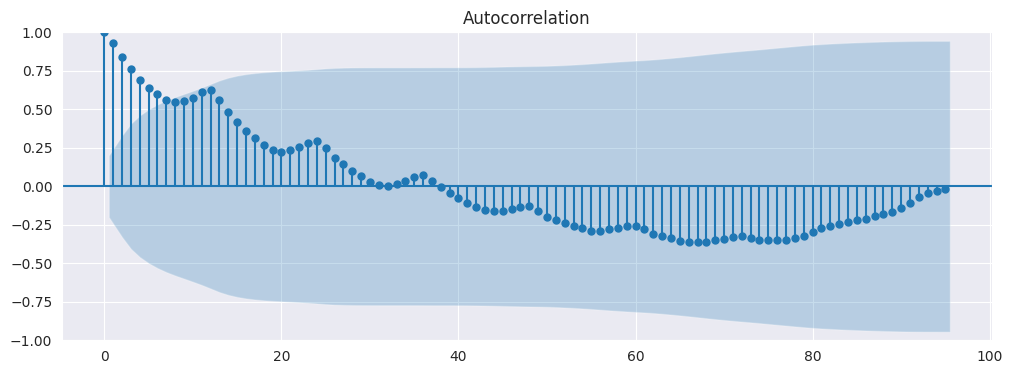

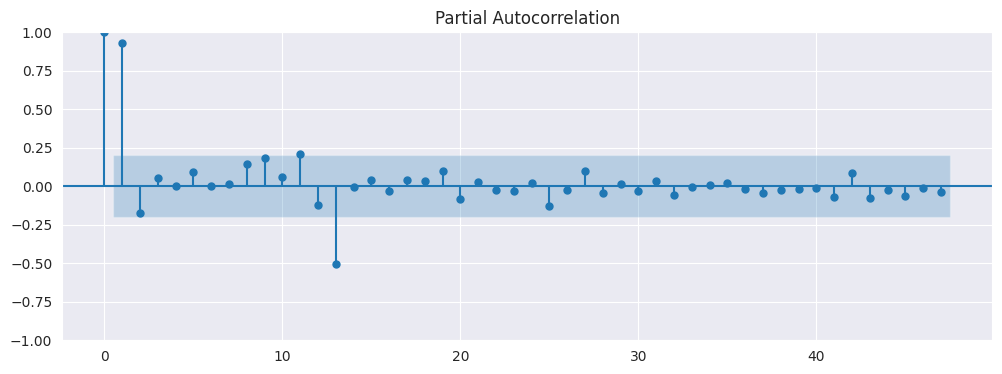

In [34]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

In [35]:
visual = df1.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual.head(10)

Passengers       date  year  month  week  quarter day_of_week
0         112 1995-01-01  1995      1    52        1      Sunday
1         118 1995-02-01  1995      2     5        1   Wednesday
2         132 1995-03-01  1995      3     9        1   Wednesday
3         129 1995-04-01  1995      4    13        2    Saturday
4         121 1995-05-01  1995      5    18        2      Monday
5         135 1995-06-01  1995      6    22        2    Thursday
6         148 1995-07-01  1995      7    26        3    Saturday
7         148 1995-08-01  1995      8    31        3     Tuesday
8         136 1995-09-01  1995      9    35        3      Friday
9         119 1995-10-01  1995     10    39        4      Sunday

In [36]:
visual.year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002])

In [37]:
# data
df_1995 = visual[visual['year']==1995][['month','Passengers']]
df_1995 = df_1995.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1995'})
df_1996 = visual[visual['year']==1996][['month','Passengers']]
df_1996 = df_1996.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1996'})
df_1997 = visual[visual['year']==1997][['month','Passengers']]
df_1997 = df_1997.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1997'})
df_1998 = visual[visual['year']==1998][['month','Passengers']]
df_1998 = df_1998.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1998'})
df_1999 = visual[visual['year']==1999][['month','Passengers']]
df_1999 = df_1999.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1999'})
df_2000 = visual[visual['year']==2000][['month','Passengers']]
df_2000 = df_2000.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2000'})
df_2001 = visual[visual['year']==2001][['month','Passengers']]
df_2001 = df_2001.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2001'})
df_2002 = visual[visual['year']==2002][['month','Passengers']]
df_2002 = df_2002.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2002'})



df_year = df_1995.merge(df_1996,on='month').merge(df_1997,on='month').merge(df_1998,on='month').merge(df_1999,on='month')\
.merge(df_2000,on='month').merge(df_2001,on='month').merge(df_2002,on='month')

# top levels
top_labels = ['1995', '1996', '1997', '1998', '1999','2000','2001','2002']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)']

# X axis value
df_year = df_year[['1995', '1996', '1997', '1998', '1999','2000','2001','2002']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1995['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1995['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))


fig.update_layout(title='Avg Passengers for each Year',
    xaxis=dict(showgrid=False,
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack',
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False,
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

![newplot-2.png](attachment:newplot-2.png)

#### Observation:

+ Highest sales are made in August and July month and then decreases in December.
+ Sales are increasing gradually from 1995 to 2002.

In [38]:
# data
import calendar
df_m_sa = visual.groupby('month').agg({"Passengers" : "mean"}).reset_index()
df_m_sa['Passengers'] = round(df_m_sa['Passengers'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Passengers'].astype(str)

df_w_sa = visual.groupby('week').agg({"Passengers" : "mean"}).reset_index()
df_q_sa = visual.groupby('quarter').agg({"Passengers" : "mean"}).reset_index()
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3],
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Passengers Analysis", "Quarter wise Avg Passengers Analysis",
                                    "Week wise Avg Passengers Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Passengers'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'),
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Passengers'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'),
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Passengers'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'),
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)],
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20),
                  title_text="Average Passengers Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

![newplot%20%281%29-3.png](attachment:newplot%20%281%29-3.png)

In [39]:
# data
df_dw_sa = visual.groupby('day_of_week').agg({"Passengers" : "mean"}).reset_index()
df_dw_sa.Passengers = round(df_dw_sa.Passengers, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Passengers', title='Avg Passengers vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Passengers',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified",
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

![newplot%20%282%29.png](attachment:newplot%20%282%29.png)

#### Observation:

+ As we saw in the above chart there is an upward trend in Number of Passengers over the time. Although there are ups and downs at every point in time, generally we can observe that the trend increases. Also we can notice how the ups and downs seem to be a bit regular, it means we might be observing a seasonal pattern here too. Let’s take a closer look by observing some year’s data:
+ Highest sales are made on Thursday.
+ July month has the highest sales.

### Time Series Decomposition

1) Seasonality
Seasonality is a simple term that means while predicting a time series data there are some months in a particular domain where the output value is at a peak as compared to other months. for example if you observe the data of tours and travels companies of past 3 years then you can see that in November and December the distribution will be very high due to holiday season and festival season. So while forecasting time series data we need to capture this seasonality.

2) Trend
The trend is also one of the important factors which describe that there is certainly increasing or decreasing trend time series, which actually means the value of organization or sales over a period of time and seasonality is increasing or decreasing.

#### Additive Seasonal Decomposition

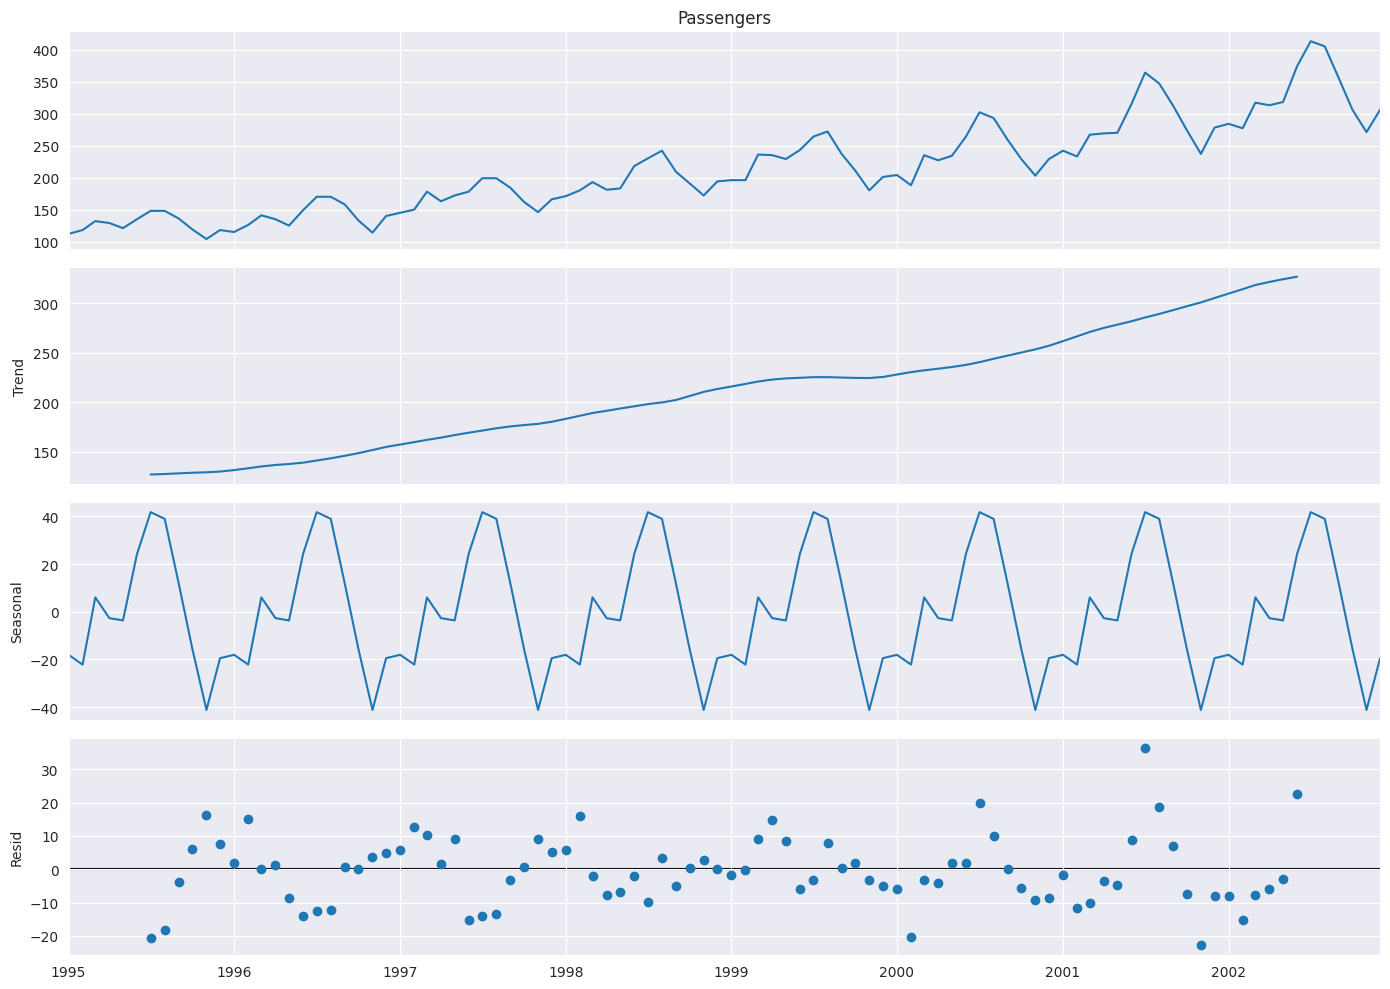

In [40]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### Observation:-
1. ***Observed*** - Actual data
2. ***Trend*** - Increasing or decreasing trend.
3. ***Seasonal*** -
    - Varies from +50 to -50 with the mean 0.
    - Each cycle represents each year trend.
    - The value in the Y-axis has to be `added` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is +50 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 50+100 = 150.
4. ***Residual*** - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

#### Multiplicative Seasonal Decomposition

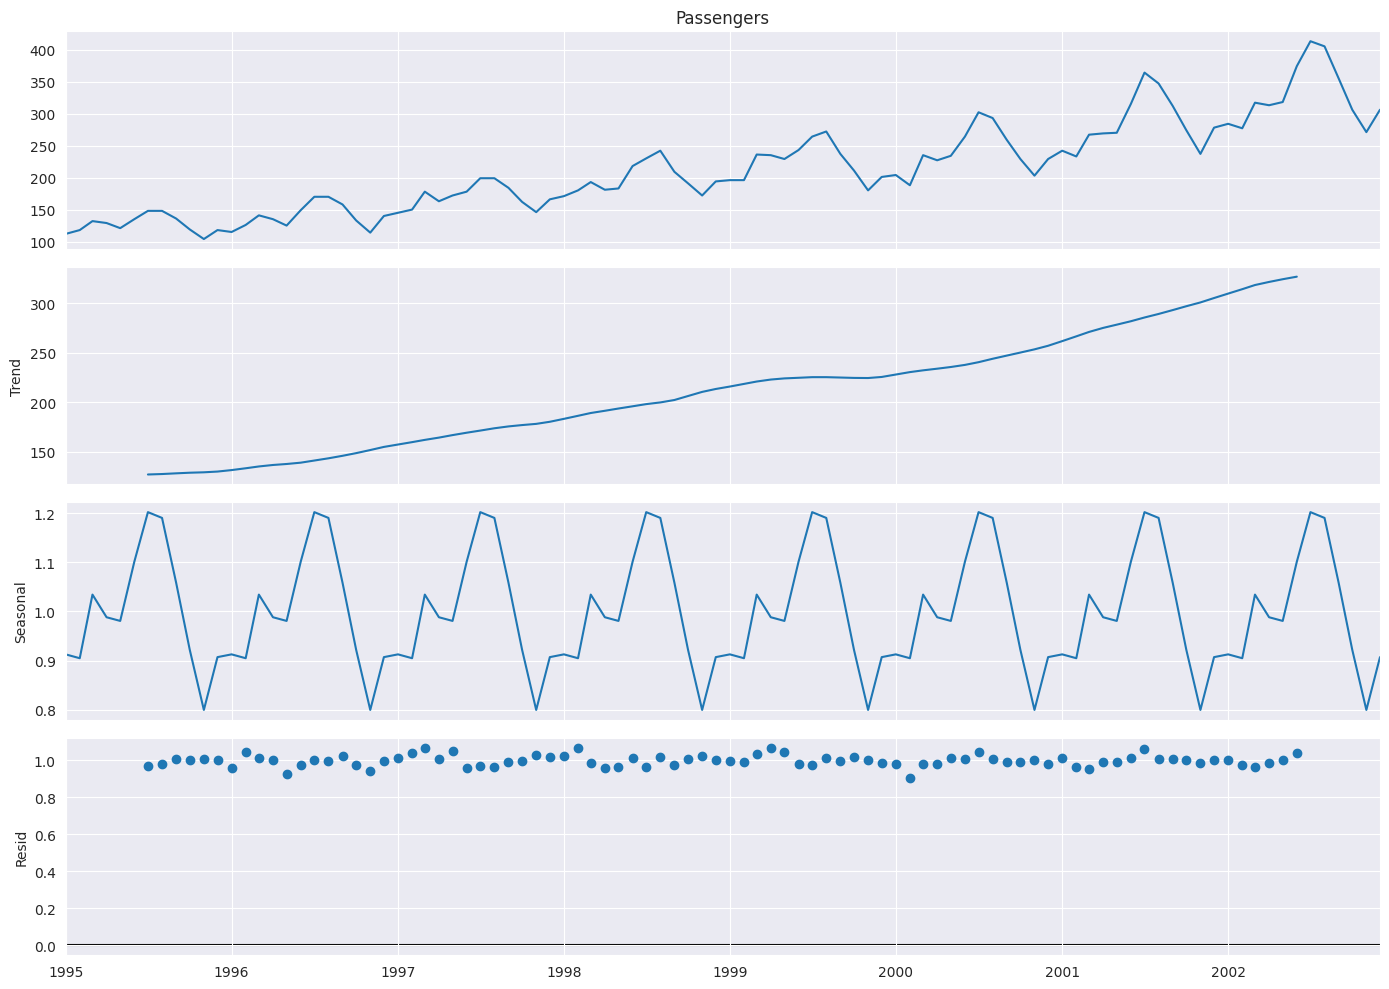

In [41]:
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### Observation:-

***Seasonal*** -
1. Varies from 0.8 to 1.2
2. The value in the Y-axis has to be `multiplied` to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is `1.2` and the trend value is `100`. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.


### Splitting Train and Test Data
#### Leaving Test Data with 2 Years of Time Series

In [42]:
size = 72
train_data = df1[:size]
test_data = df1[size:]

In [43]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


We are going to forecat for the last two years. 2001 and 2002.

Last 24 records contain From 2001 to 2002 data.

<Axes: xlabel='Date'>

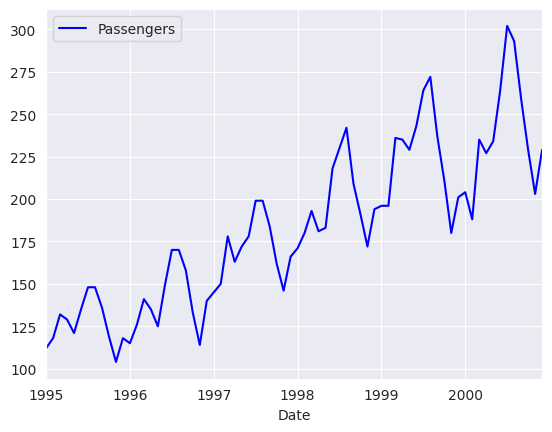

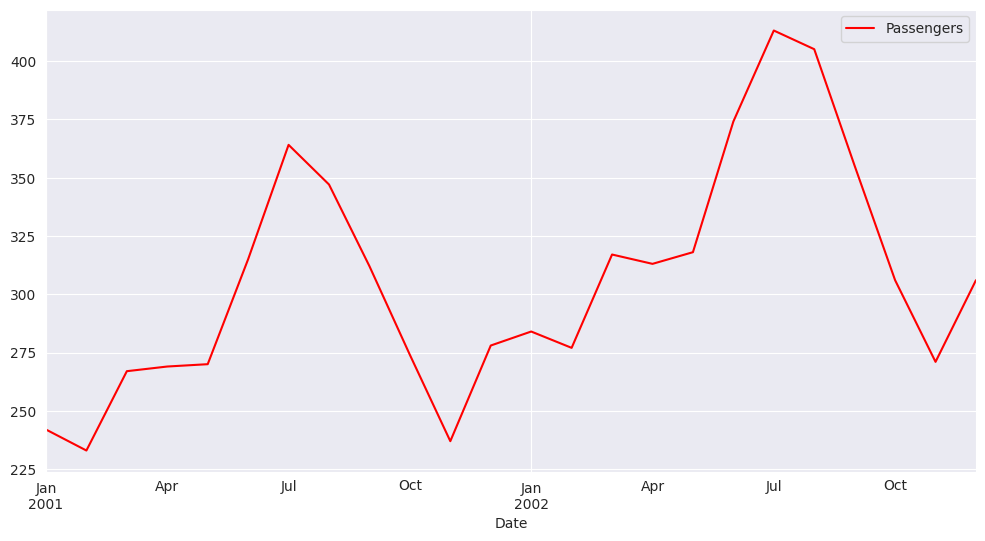

In [44]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

### Evaluation Metric MAPE

In [45]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

___
## Exponential Methods
### Simple Exponential Method

#### Using Forecast Attribute

In [46]:
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 23.38228335004472 
 Train Root Mean Squared Error = 19.031771730910982 
 Test Root Mean Squared Error = 91.11325402904403


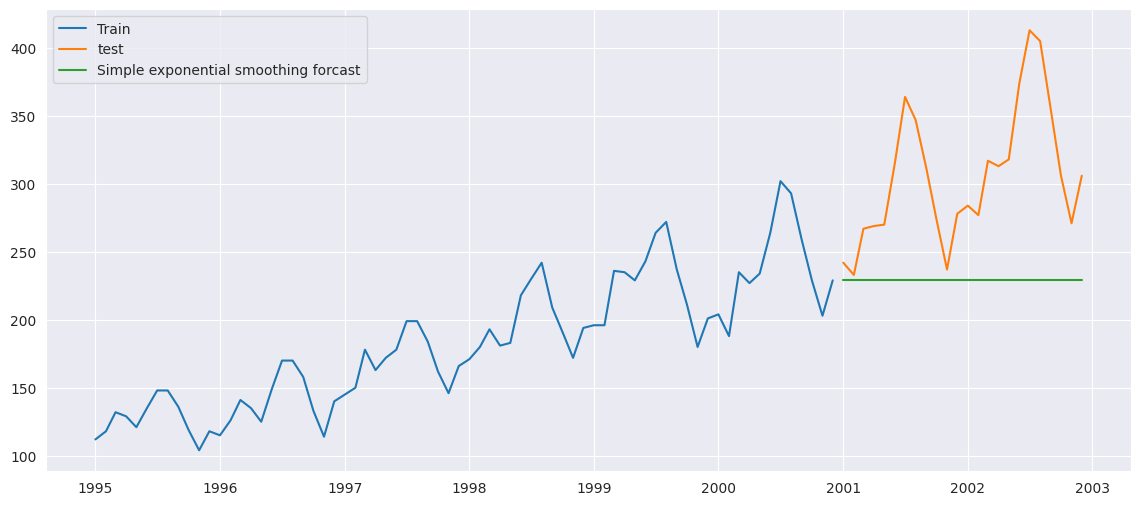

In [47]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### Observation
1. No seasonality captures.
2. Most recent observation gets higher weightages than the older ones for forecasting.

---
### Holt method (Double Exponential)

##### Captures both Level and Trend .

In [48]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 13.785654299480264 
 Train Root Mean Squared Error = 19.302273510811172 
 Test Root Mean Squared Error = 59.95281084692555


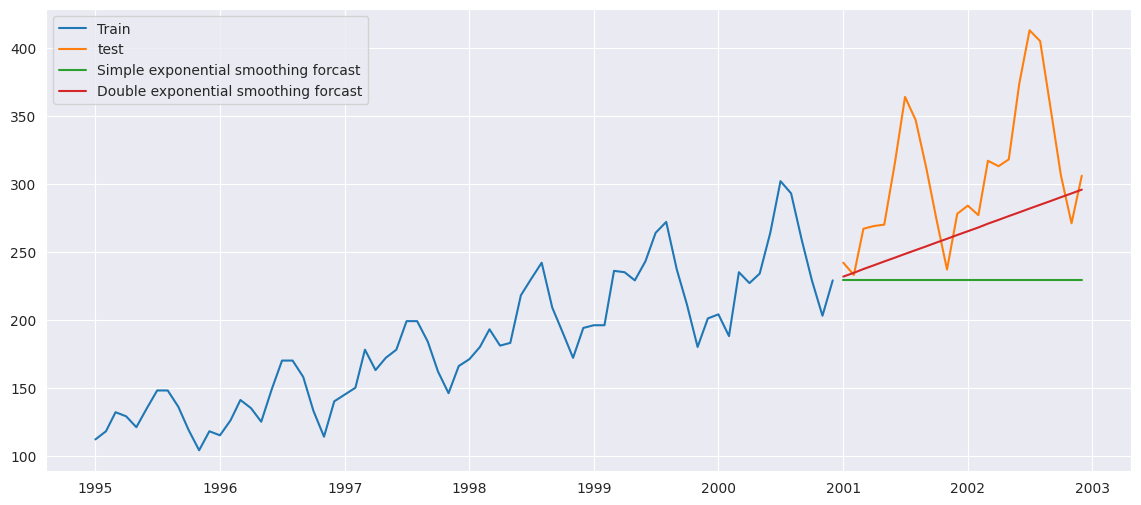

In [49]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [50]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 12.084813658780355 
 Train Root Mean Squared Error = 7.751303513604031 
 Test Root Mean Squared Error = 47.570269203462864


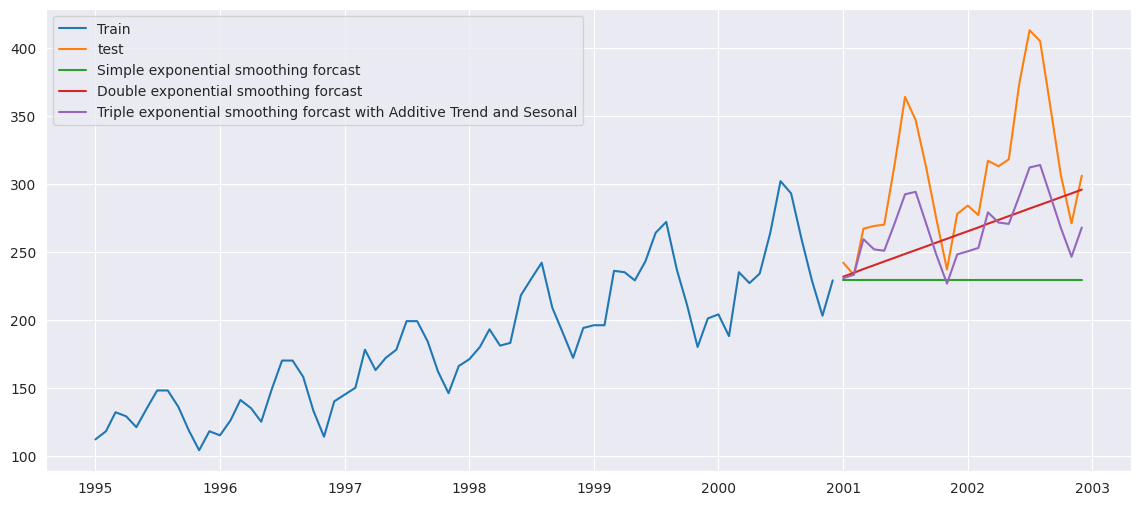

In [51]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

#### Observation
1. It captures the trend, which we can see that the forecasted values are lower level than the test level.
2. It also captures the seasonality.
3. The peak of the forecasted value is lower than the actual.

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [52]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 9.368409298996491 
 Train Root Mean Squared Error = 6.386634437268093 
 Test Root Mean Squared Error = 34.98955392874329


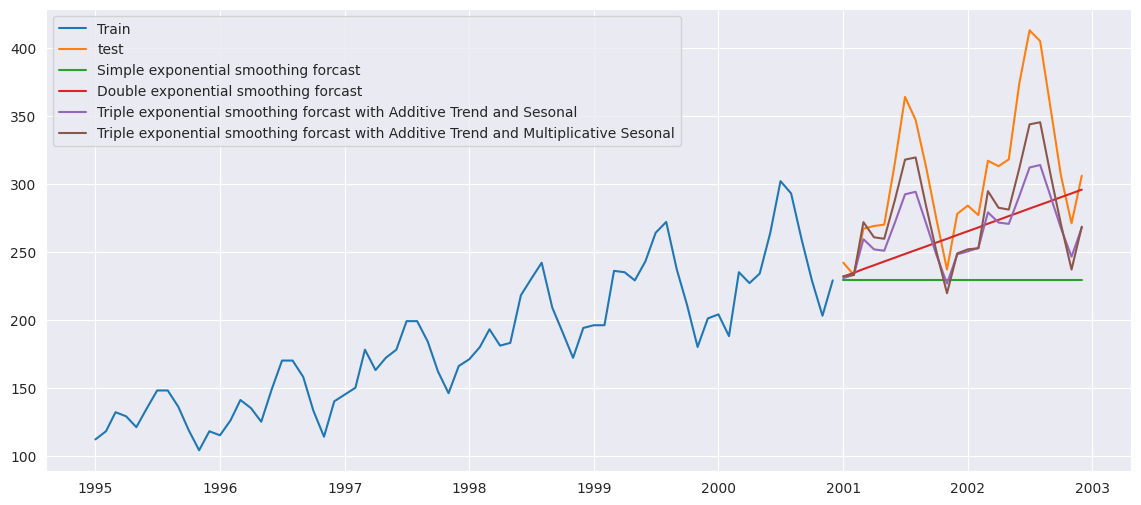

In [53]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [54]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Passengers))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Passengers)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 13.341866948862238 
 Train Root Mean Squared Error = 12.755539751240624 
 Test Root Mean Squared Error = 48.34208410593296


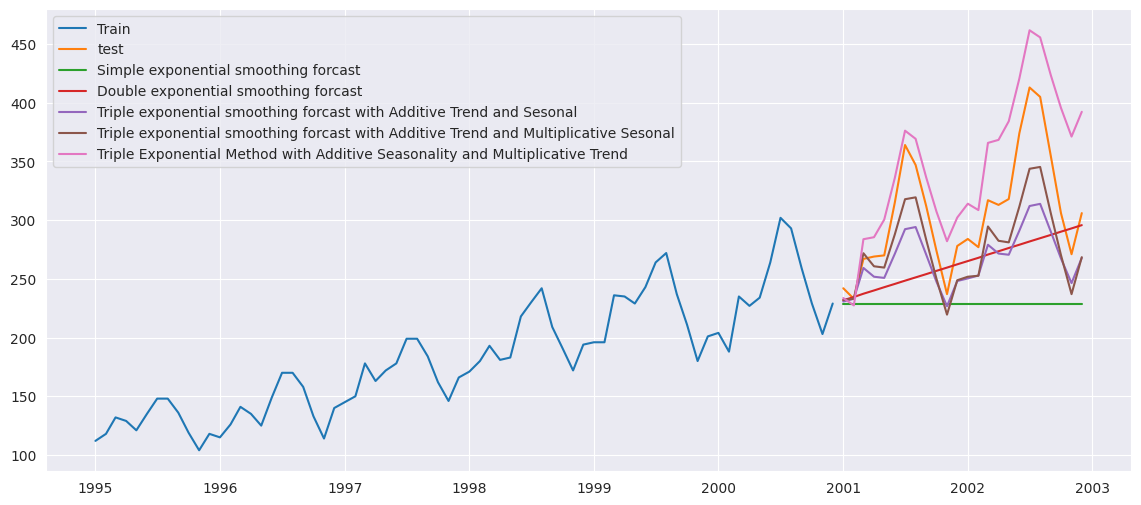

In [55]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

#### Observation
1. It captures the trend, which we can see that the forecasted values are higher level than the test level.
2. It also captures the seasonality.
3. The peak of the forecasted value is higher than the actual.

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [56]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Passengers))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Passengers)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 6.035078693970935 
 Train Root Mean Squared Error = 6.396749786818969 
 Test Root Mean Squared Error = 23.058842144878668


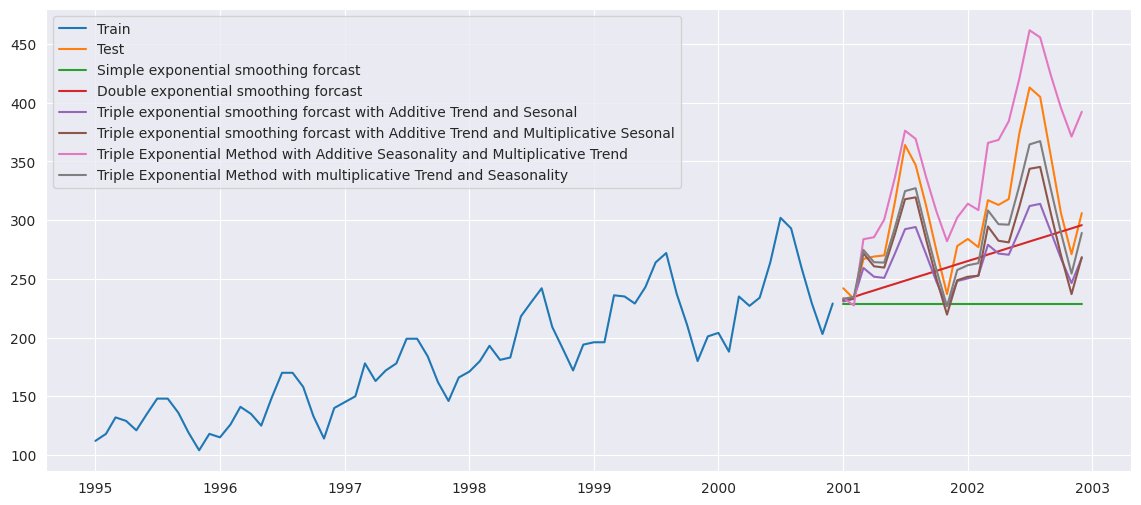

In [57]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [58]:
#Comparing the results

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0     Triple_Exp_mul    6.396750      6.035079         23.058842
1  Triple_Exp_mul_ad    6.386634      9.368409         34.989554
2      Triple_Exp_ad    7.751304     12.084814         47.570269
3  Triple_Exp_ad_mul   12.755540     13.341867         48.342084
4         Double_Exp   19.302274     13.785654         59.952811
5         Simple_Exp   19.031772     23.382283         91.113254

### Visualizing Models Performance

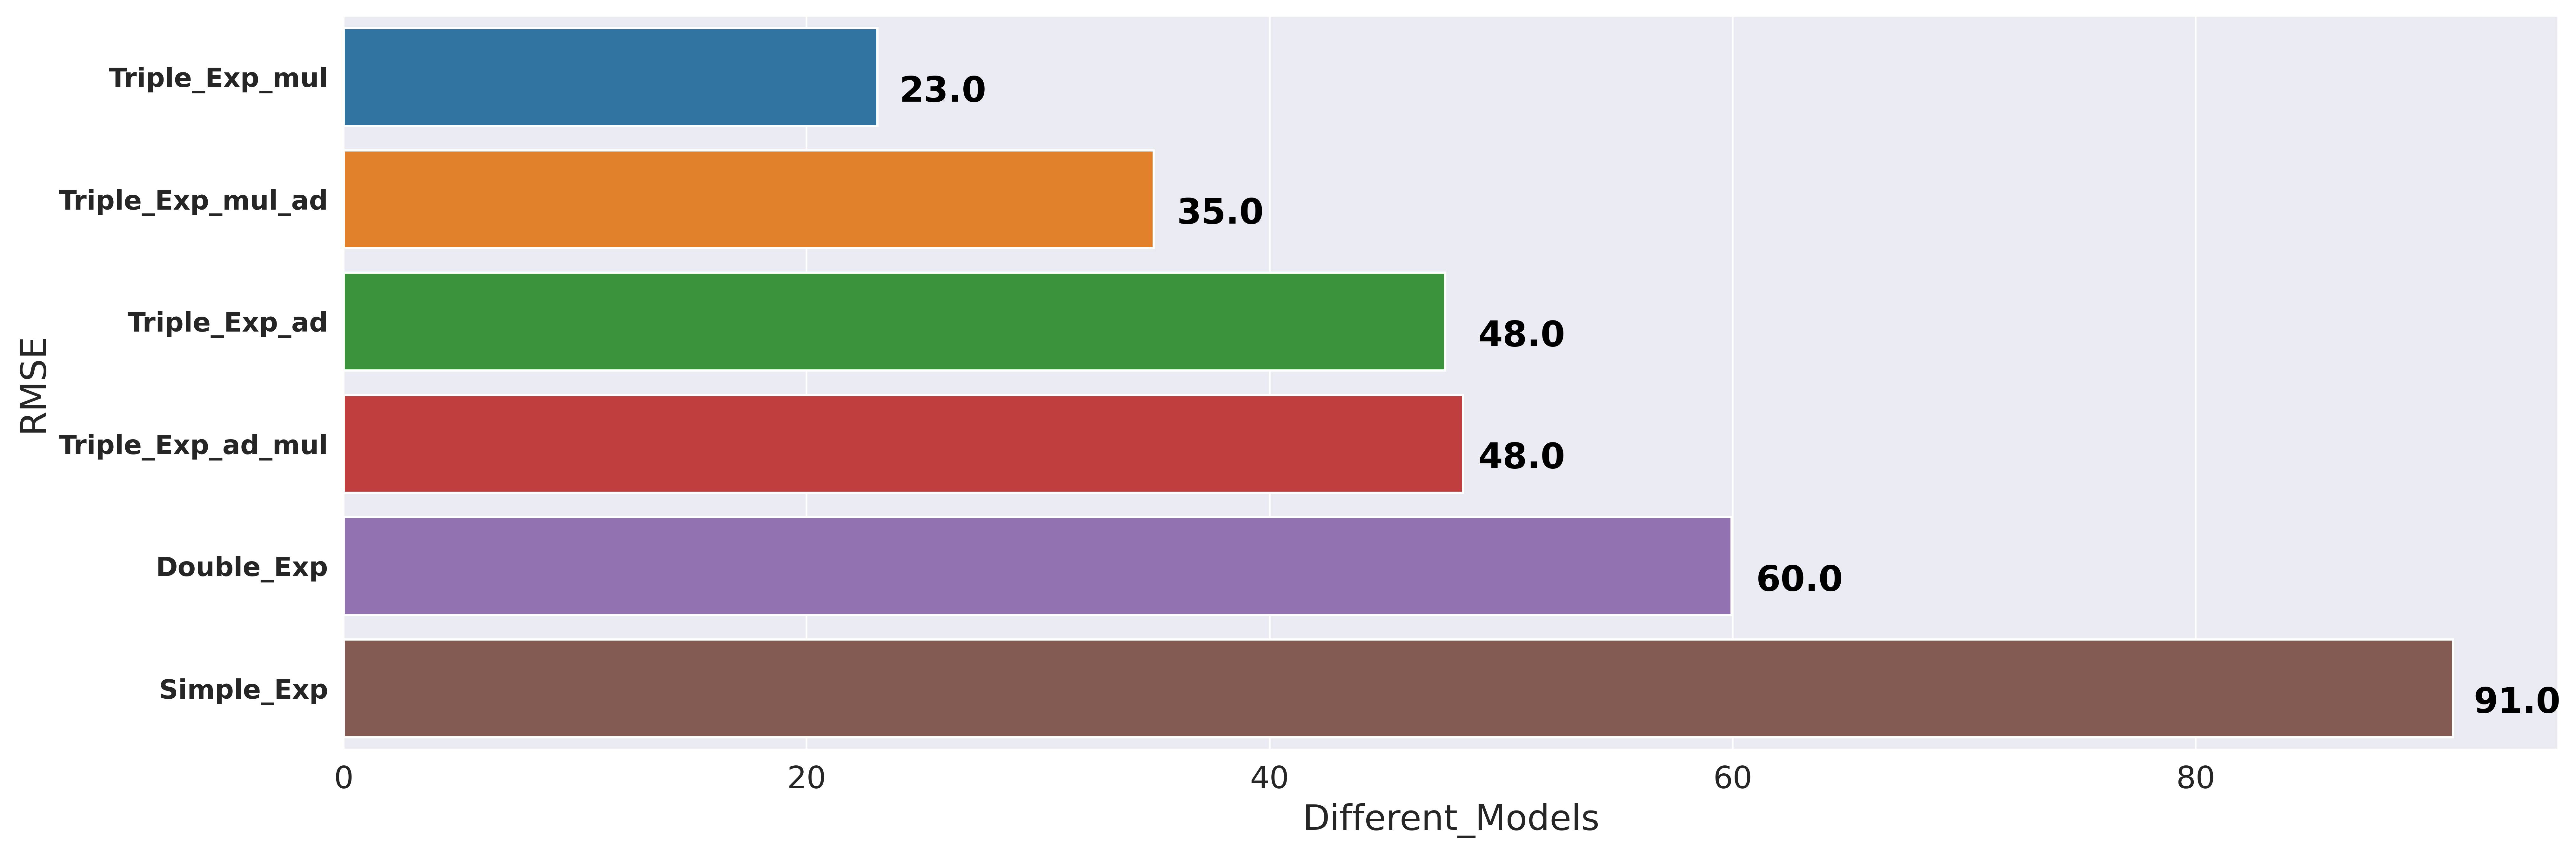

In [59]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

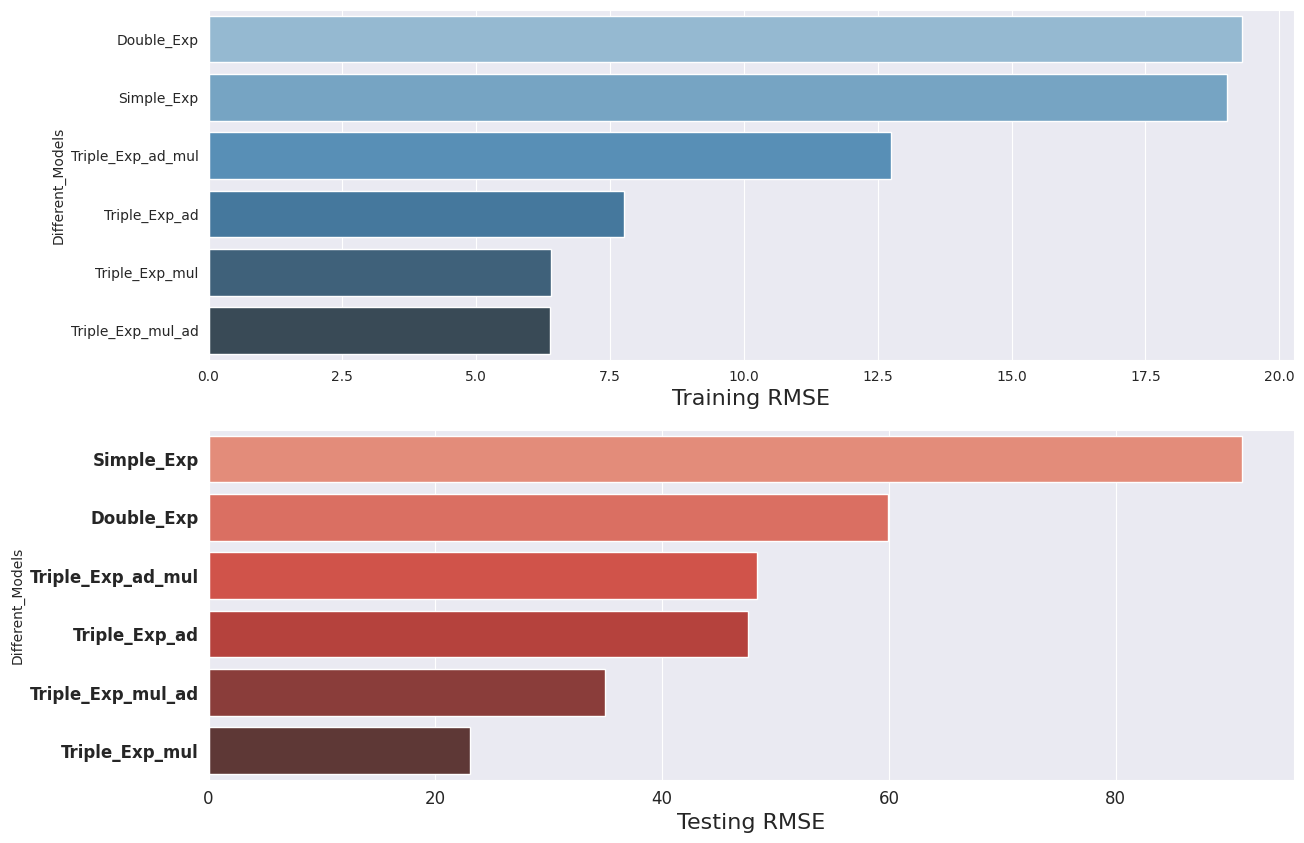

In [60]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$
#### Stationary vs Non-stationary Time Series

### Test of Stationarity

##### As we have yearly data the window size for moving average is equal to 12

In [61]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Augmented Dicky Fuller Test
Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05

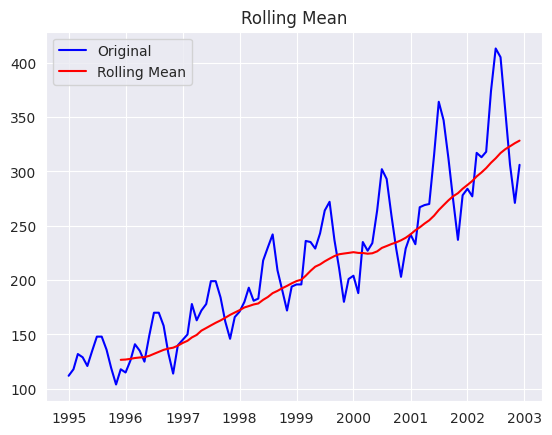

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [62]:
sales= pd.DataFrame()
sales['Passengers'] = df1[['Passengers']]
test_stationarity(sales)

In [63]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [64]:
adf_test(sales)

Fail to reject the null hypothesis
Data is non-stationary


### Feature Scaling (Transformations)

#### Square Root Transform

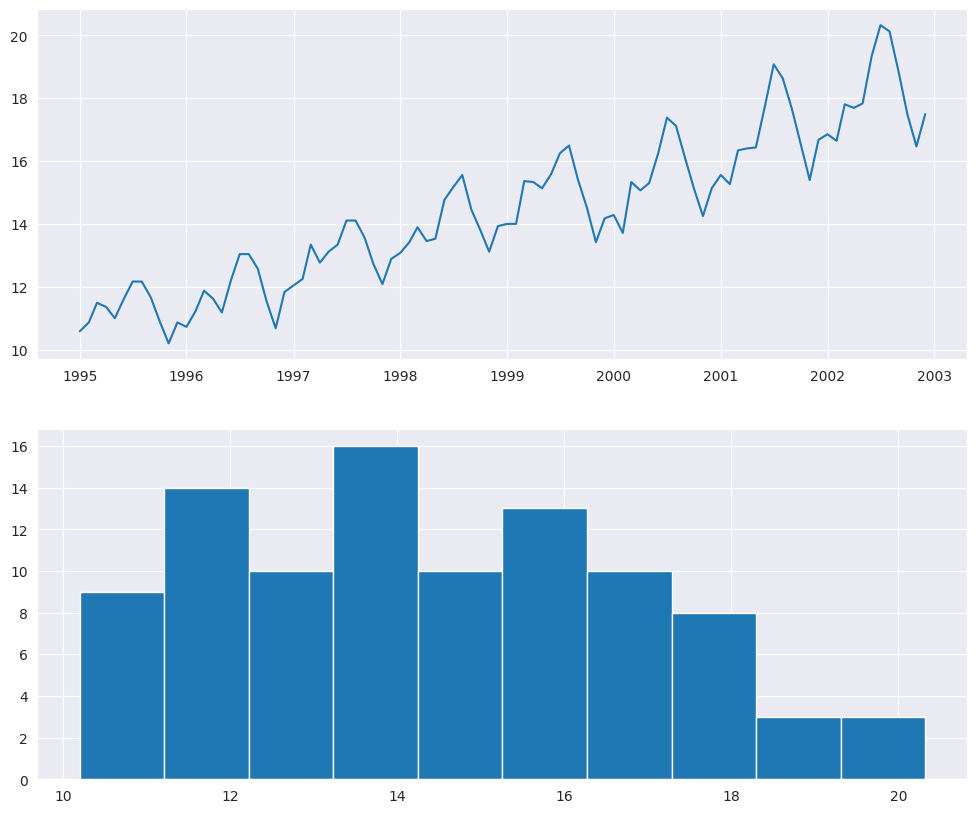

In [65]:
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

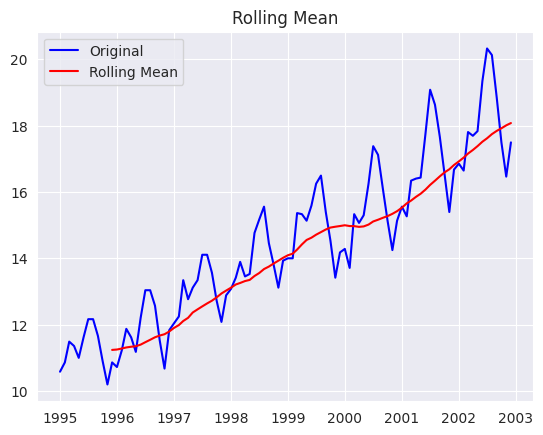

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [66]:
test_stationarity(square_root)

In [67]:
adf_test(square_root)

Fail to reject the null hypothesis
Data is non-stationary


#### Log Transform

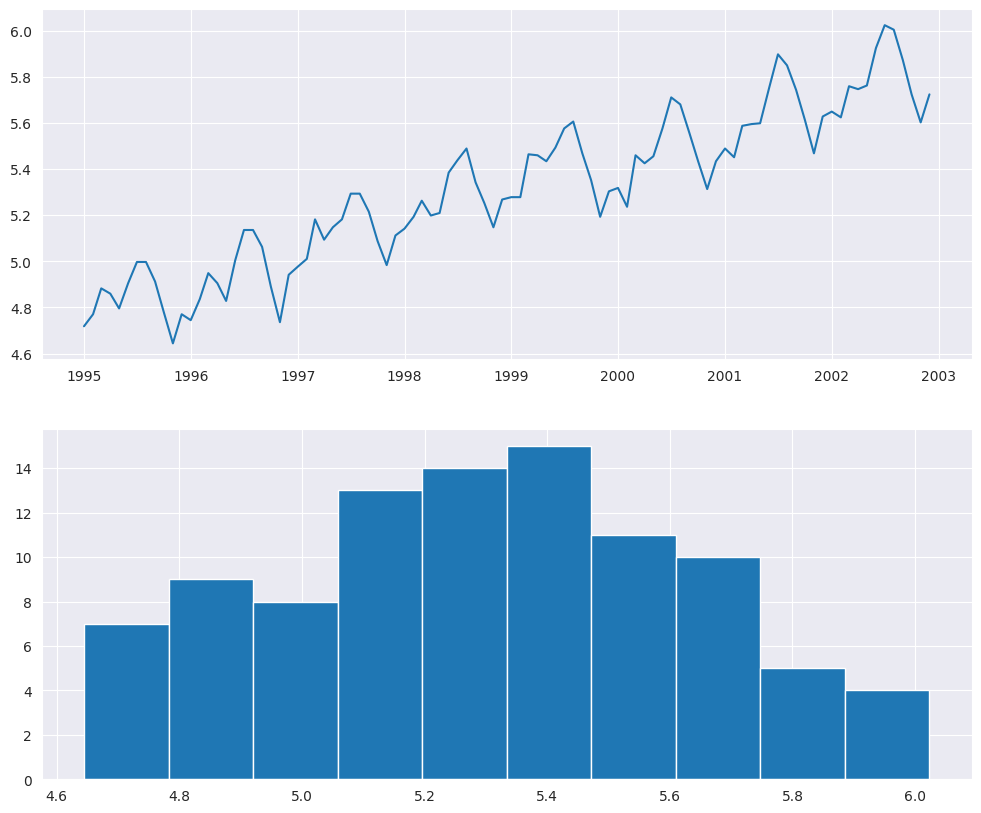

In [68]:
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

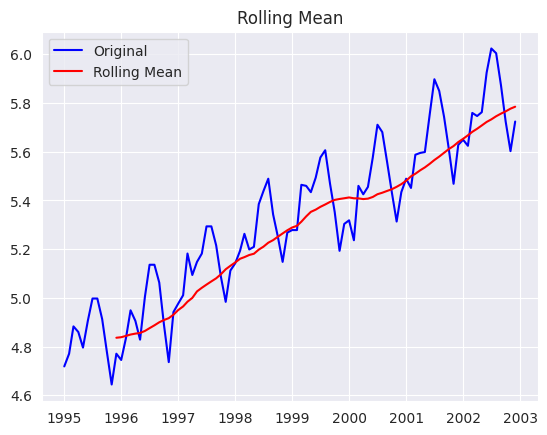

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [69]:
test_stationarity(log)

In [70]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


##### Hence, the Time series data is Non-Stationary

### Converting Non-Stationary Time Series into Stationary

#### Differencing
In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t

Applying differencing on our series and plotting the results:

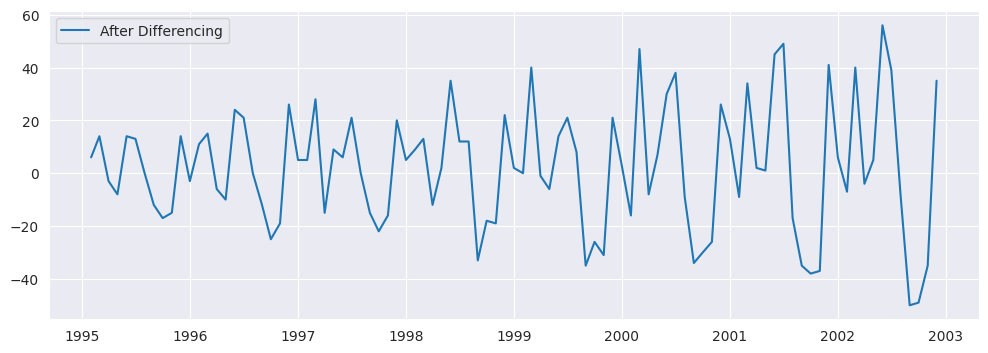

In [71]:
differencing = df1 - df1.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

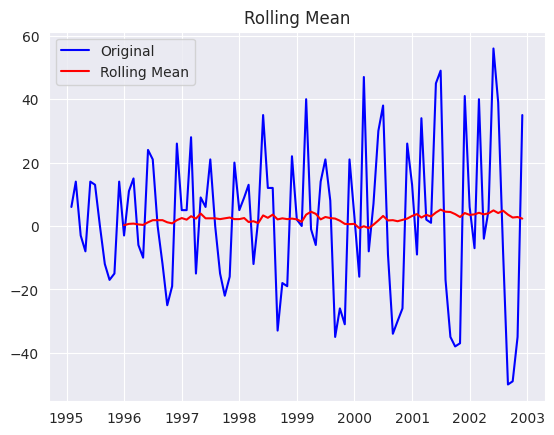

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [72]:
test_stationarity(differencing)

In [73]:
adf_test(differencing)

Fail to reject the null hypothesis
Data is non-stationary


#### Seasonal Differencing
In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

yt‘ = yt – y(t-n)

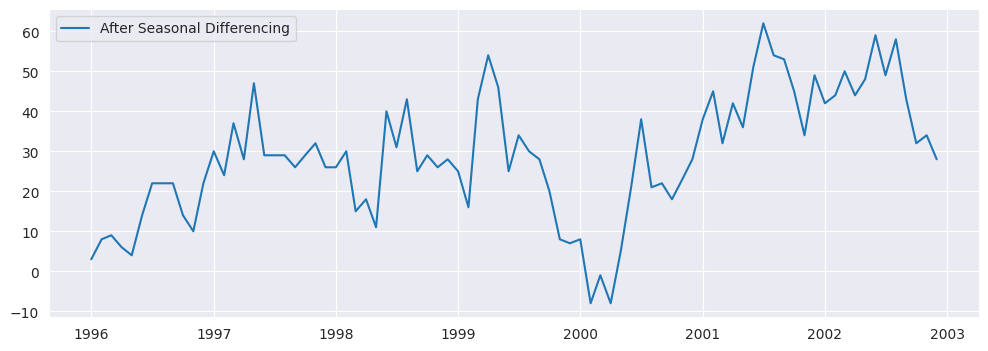

In [74]:
seasonal_differencing = df1 - df1.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

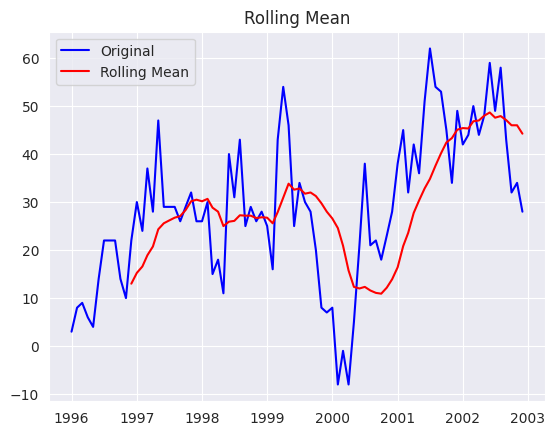

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [75]:
test_stationarity(seasonal_differencing)

In [76]:
adf_test(seasonal_differencing)

Fail to reject the null hypothesis
Data is non-stationary


#### Transformation
Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. Let’s do a quick log transform and differencing on our air passenger dataset:

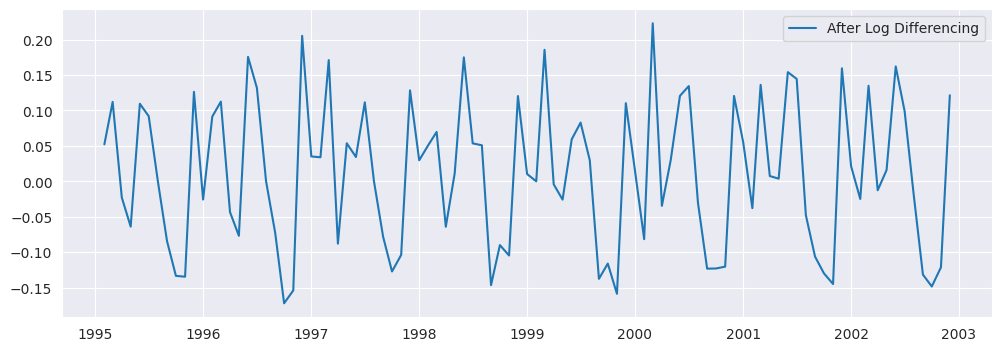

In [77]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

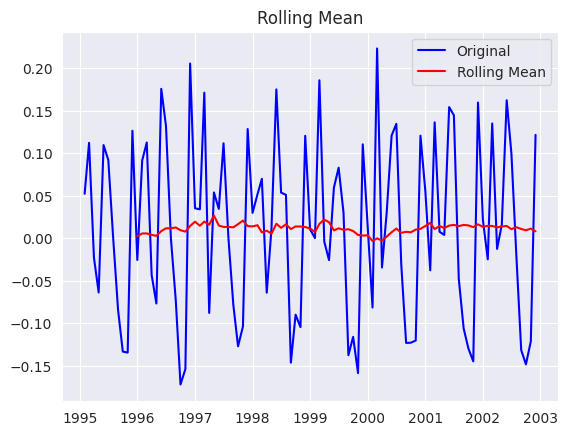

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [78]:
test_stationarity(log_diff)

In [79]:
adf_test(log_diff)

Fail to reject the null hypothesis
Data is non-stationary


#### Box Cox Transformation

Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791

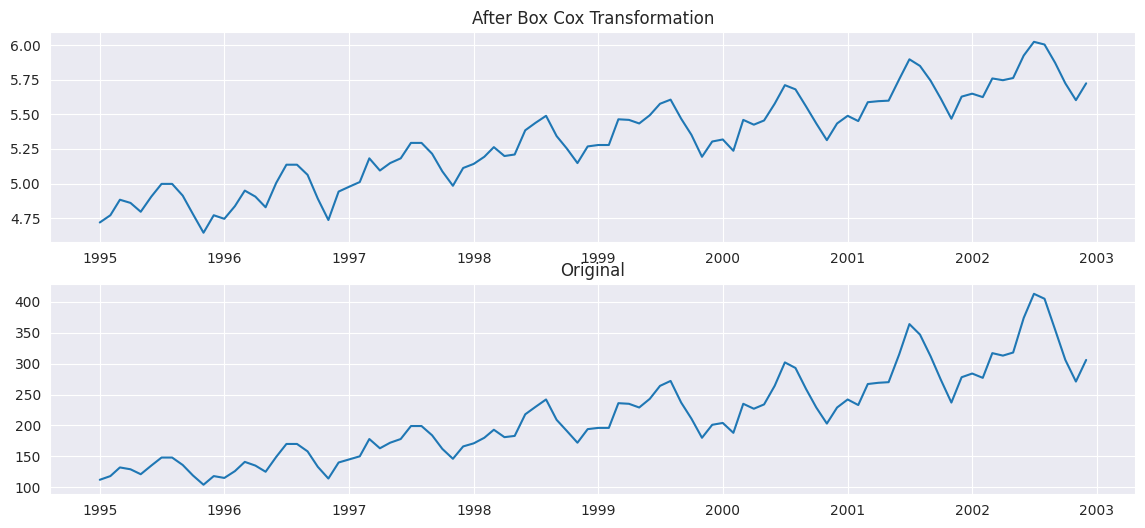

In [80]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1, label='original')
axis[1].set_title('Original')
plt.show()

#### Observation
1. We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
2. But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do `Differencing` for making the mean constant.

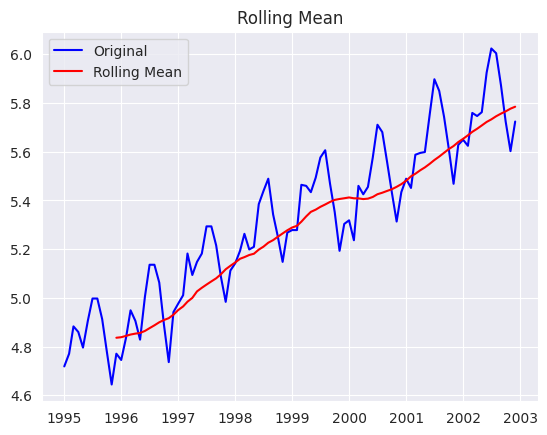

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [81]:
test_stationarity(data_boxcox)

In [82]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


#### Differencing of the Box-Cox Transformation
Differencing is performed by subtracting the previous observation from the current observation.

Differencing removes trend and seasonality in a Time series. When an entire cycle is used for differencing the other cycle, then the seasonality is removed.

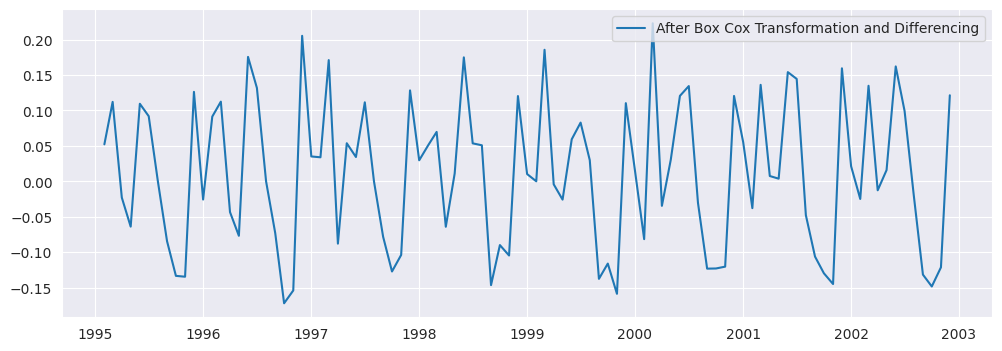

In [83]:
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation.
2. It is a horizontal trend.
3. The mean became constant. The mean is zero.
4. Also, the variance is almost constant.

Lets test the Stationarity again.

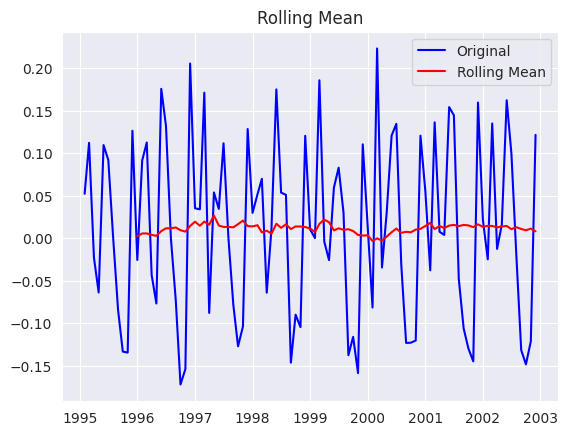

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [84]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [85]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


##### Finally, Our Series is now stationary for AR Forecasting

#### ARIMA Hyperparameter Tuning

***order(p,d,q)***

p = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series.

d = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.


q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality.

In [86]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [87]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(data_boxcox_diff.Passengers, p_values, d_values, q_values)

KeyboardInterrupt: ignored

#### Building The Time Series Forecasting with Optimal Value using ARIMA
Automatically performs the Differencing if the series has trend.

Hence, no need to manually perform the differencing.

In [ ]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

##### Inverse transformation of the Box-Cox Differencing
As we have converted the original time series to Stationary series by consecutively applying BoxCox transformation and Differencing. We have to transform the series back to the original one (step by step).

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
# Now doing the reverse transformation
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

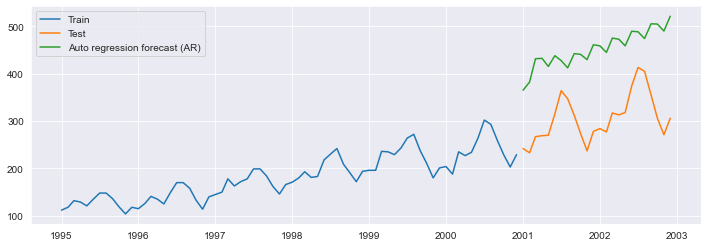

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [ ]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

152.7

#### MAPE (Mean Absolute Percent Error)

In [ ]:
mape_arima = round(np.mean(np.abs((test_data.Passengers - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_arima

50.3

#### Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [ ]:
model_residual = model_fit.resid
model_residual.mean()

-0.00570903124466612

#### Residuals must be stationary

In [ ]:
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


#### No autocorrelation between residuals

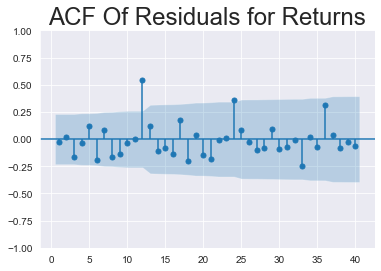

In [ ]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

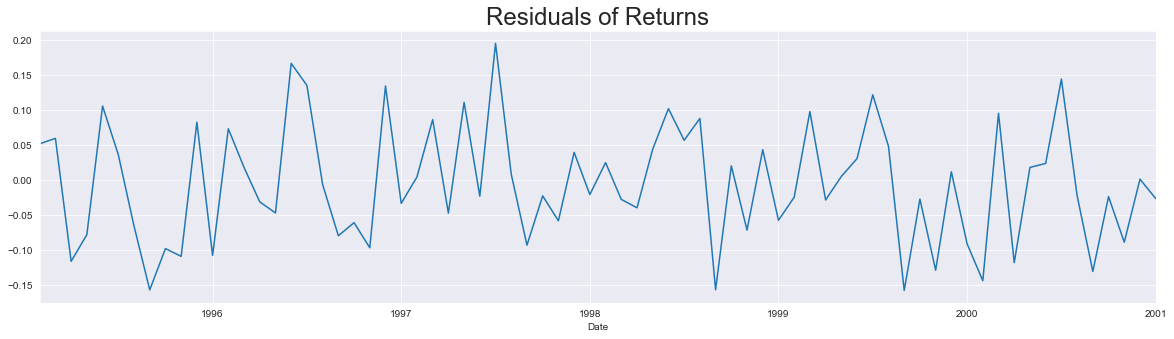

In [ ]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [ ]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

#### Inverse Transformation of the Differencing Box-Cox Transformation
Note that ARIMAM automatically takes care of the reversing of `Differencing` (takes care the `Integration` part automatically). So, we don't need to perform the cumsum here. We only have to do the reverse of the log boc cox transformation.

In ARIMA, we had to perform the cumsum manually.

In [ ]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

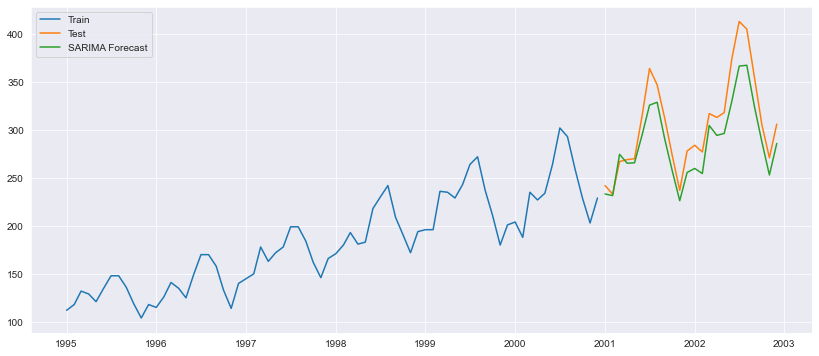

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

##### We can see that we are able to capture the trend and seasonality both.

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [ ]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

23.54

#### MAPE (Mean Absolute Percent Error)

In [ ]:
mape_sarima = round(np.mean(np.abs((test_data.Passengers - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_sarima

6.29

#### Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [ ]:
model_residual = model_fit.resid
model_residual.mean()

0.03594193482414866

#### Residuals must be stationary

In [ ]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

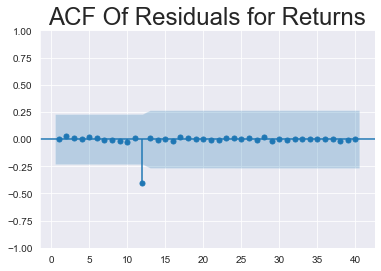

In [ ]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

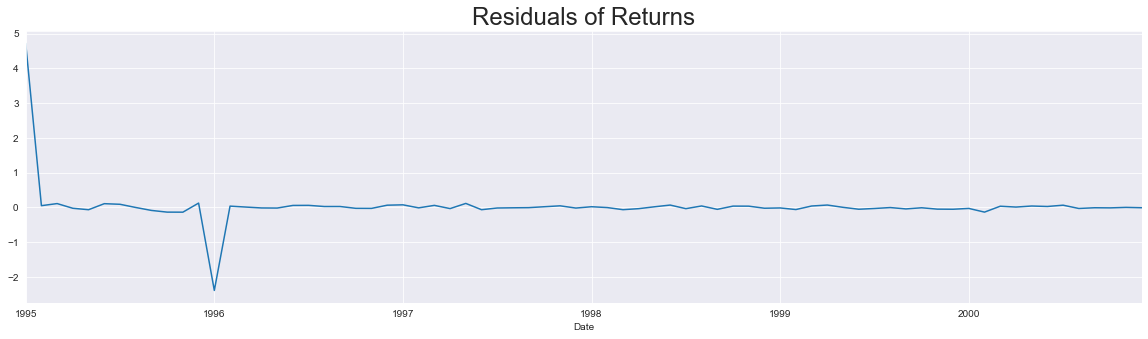

In [ ]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with differente Transformation Technique

In [ ]:
#Compareing the results

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models    MAPE(%)  RMSE_Values
0  Triple_Exp_multiplicative   6.034484    23.056799
1                     SARIMA   6.290000    23.540000
2          Triple_Exp_mul_ad   9.368355    34.989365
3          Triple_Exp_ad_mul  12.932828    46.728647
4        Triple_Exp_additive  12.084509    47.569283
5         Double_Exponential  17.148982    71.634643
6         Simple_Exponential  23.382283    91.113254
7                      ARIMA  50.300000   152.700000

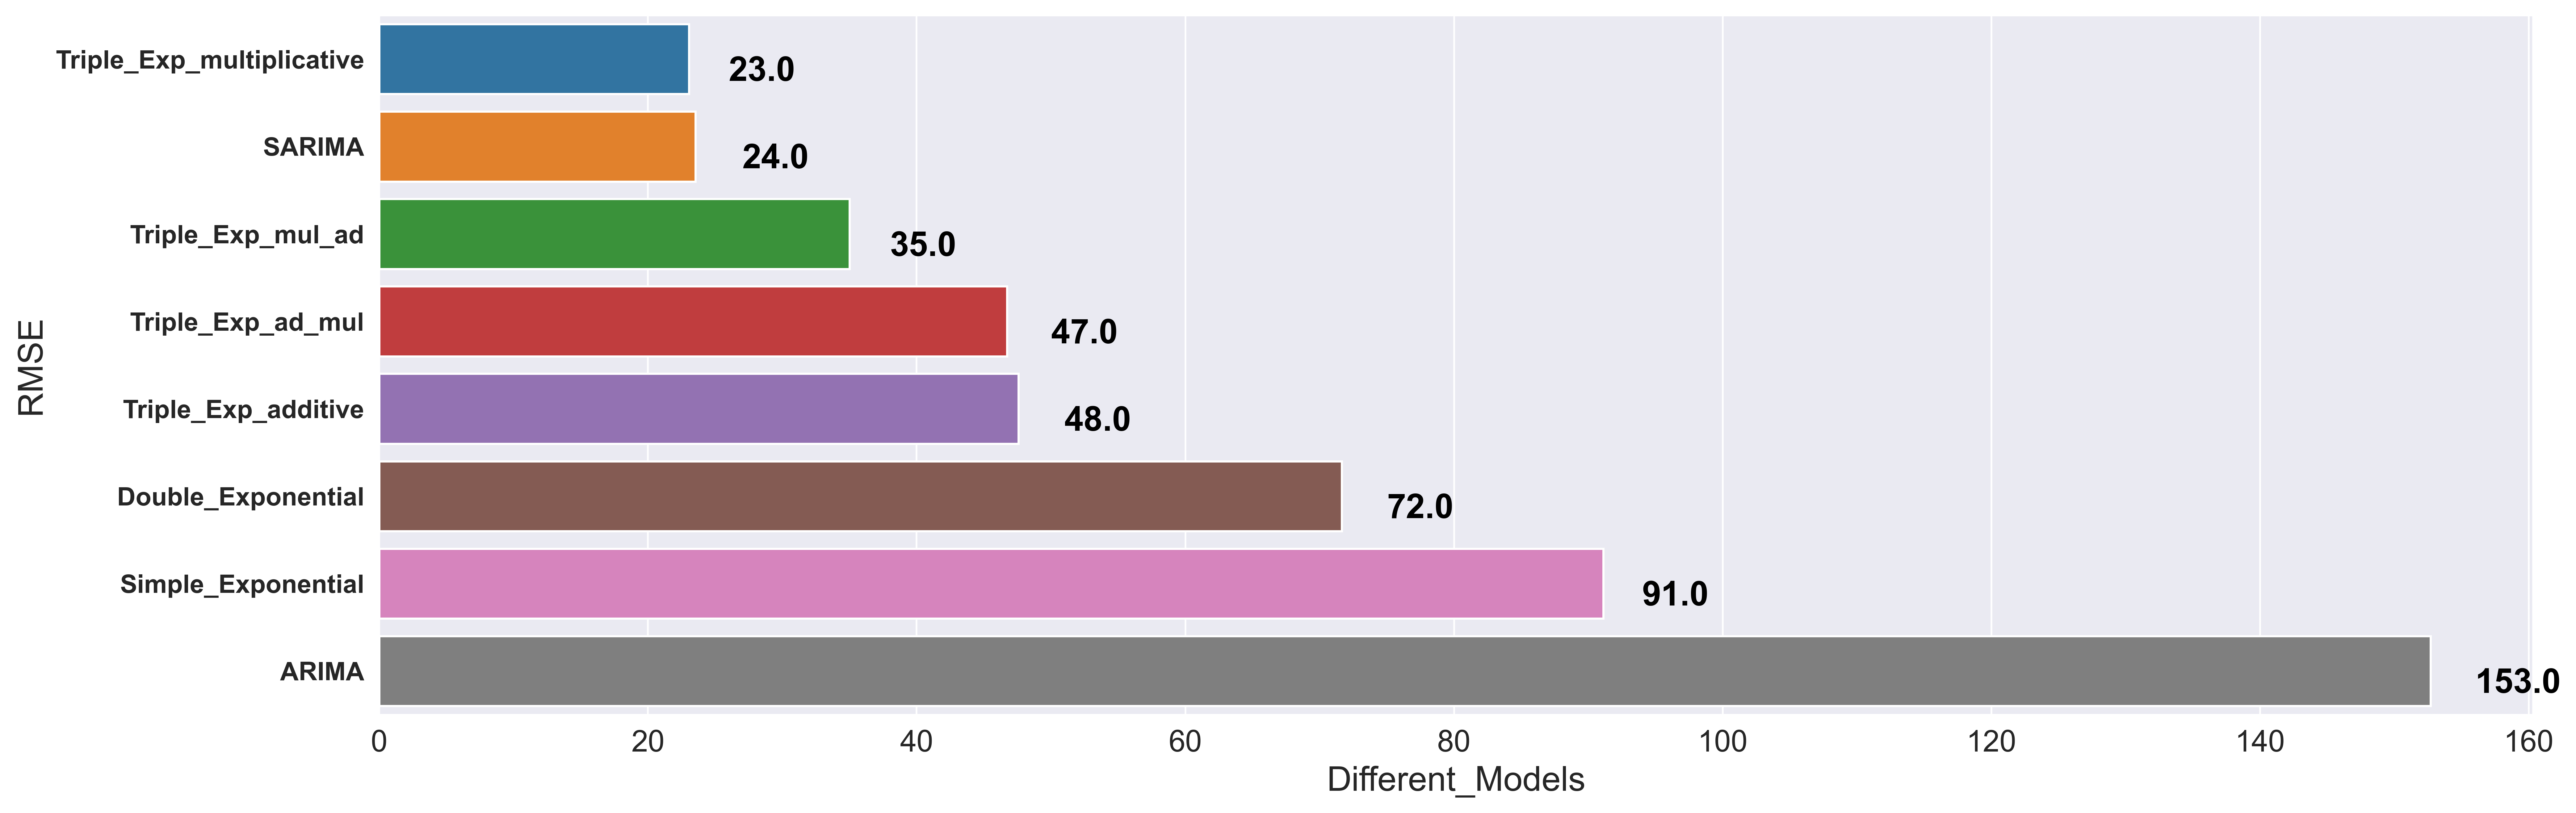

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#### Observation:
+ **The Sarima Model did very well as compared to other Models but Holts-Winter Method did slightly better**
**Note:Sarima with Hyperparameter tuning may get better results**
+ **Even in methods such as Triple Exponential Smoothing (Holts-Winters Method) taking Seasonality and Trend as Multiplicative gave the best restult in this case**

### Data Pre-processing for Model Driven Techniques

#### Creating Dummy Variables of the Categorical Feature Month of Date Time feature

In [ ]:
cocacola = df1.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
0  1995-01-01         112   1          1   Jan  1995    1    0    0    0    0   
1  1995-02-01         118   2          4   Feb  1995    0    1    0    0    0   
2  1995-03-01         132   3          9   Mar  1995    0    0    1    0    0   
3  1995-04-01         129   4         16   Apr  1995    0    0    0    1    0   
4  1995-05-01         121   5         25   May  1995    0    0    0    0    1   
..        ...         ...  ..        ...   ...   ...  ...  ...  ...  ...  ...   
91 2002-08-01         405  92       8464   Aug  2002    0    0    0    0    0   
92 2002-09-01         355  93       8649   Sep  2002    0    0    0    0    0   
93 2002-10-01         306  94       8836   Oct  2002    0    0    0    0    0   
94 2002-11-01         271  95       9025   Nov  2002    0    0    0    0    0   
95 2002-12-01         306  96       9216   Dec  2002    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
0     0    0    0    0    0    0    0        4.718499  
1     0    0    0    0    0    0    0        4.770685  
2     0    0    0    0    0    0    0        4.882802  
3     0    0    0    0    0    0    0        4.859812  
4     0    0    0    0    0    0    0        4.795791  
..  ...  ...  ...  ...  ...  ...  ...             ...  
91    0    0    1    0    0    0    0        6.003887  
92    0    0    0    1    0    0    0        5.872118  
93    0    0    0    0    1    0    0        5.723585  
94    0    0    0    0    0    1    0        5.602119  
95    0    0    0    0    0    0    1        5.723585  

[96 rows x 19 columns]

#### Splitting data into Train and Test

In [ ]:
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [ ]:
train_data

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
0  1995-01-01         112   1          1   Jan  1995    1    0    0    0    0   
1  1995-02-01         118   2          4   Feb  1995    0    1    0    0    0   
2  1995-03-01         132   3          9   Mar  1995    0    0    1    0    0   
3  1995-04-01         129   4         16   Apr  1995    0    0    0    1    0   
4  1995-05-01         121   5         25   May  1995    0    0    0    0    1   
..        ...         ...  ..        ...   ...   ...  ...  ...  ...  ...  ...   
67 2000-08-01         293  68       4624   Aug  2000    0    0    0    0    0   
68 2000-09-01         259  69       4761   Sep  2000    0    0    0    0    0   
69 2000-10-01         229  70       4900   Oct  2000    0    0    0    0    0   
70 2000-11-01         203  71       5041   Nov  2000    0    0    0    0    0   
71 2000-12-01         229  72       5184   Dec  2000    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
0     0    0    0    0    0    0    0        4.718499  
1     0    0    0    0    0    0    0        4.770685  
2     0    0    0    0    0    0    0        4.882802  
3     0    0    0    0    0    0    0        4.859812  
4     0    0    0    0    0    0    0        4.795791  
..  ...  ...  ...  ...  ...  ...  ...             ...  
67    0    0    1    0    0    0    0        5.680173  
68    0    0    0    1    0    0    0        5.556828  
69    0    0    0    0    1    0    0        5.433722  
70    0    0    0    0    0    1    0        5.313206  
71    0    0    0    0    0    0    1        5.433722  

[72 rows x 19 columns]

In [ ]:
test_data

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
72 2001-01-01         242  73       5329   Jan  2001    1    0    0    0    0   
73 2001-02-01         233  74       5476   Feb  2001    0    1    0    0    0   
74 2001-03-01         267  75       5625   Mar  2001    0    0    1    0    0   
75 2001-04-01         269  76       5776   Apr  2001    0    0    0    1    0   
76 2001-05-01         270  77       5929   May  2001    0    0    0    0    1   
77 2001-06-01         315  78       6084   Jun  2001    0    0    0    0    0   
78 2001-07-01         364  79       6241   Jul  2001    0    0    0    0    0   
79 2001-08-01         347  80       6400   Aug  2001    0    0    0    0    0   
80 2001-09-01         312  81       6561   Sep  2001    0    0    0    0    0   
81 2001-10-01         274  82       6724   Oct  2001    0    0    0    0    0   
82 2001-11-01         237  83       6889   Nov  2001    0    0    0    0    0   
83 2001-12-01         278  84       7056   Dec  2001    0    0    0    0    0   
84 2002-01-01         284  85       7225   Jan  2002    1    0    0    0    0   
85 2002-02-01         277  86       7396   Feb  2002    0    1    0    0    0   
86 2002-03-01         317  87       7569   Mar  2002    0    0    1    0    0   
87 2002-04-01         313  88       7744   Apr  2002    0    0    0    1    0   
88 2002-05-01         318  89       7921   May  2002    0    0    0    0    1   
89 2002-06-01         374  90       8100   Jun  2002    0    0    0    0    0   
90 2002-07-01         413  91       8281   Jul  2002    0    0    0    0    0   
91 2002-08-01         405  92       8464   Aug  2002    0    0    0    0    0   
92 2002-09-01         355  93       8649   Sep  2002    0    0    0    0    0   
93 2002-10-01         306  94       8836   Oct  2002    0    0    0    0    0   
94 2002-11-01         271  95       9025   Nov  2002    0    0    0    0    0   
95 2002-12-01         306  96       9216   Dec  2002    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
72    0    0    0    0    0    0    0        5.488938  
73    0    0    0    0    0    0    0        5.451038  
74    0    0    0    0    0    0    0        5.587249  
75    0    0    0    0    0    0    0        5.594711  
76    0    0    0    0    0    0    0        5.598422  
77    1    0    0    0    0    0    0        5.752573  
78    0    1    0    0    0    0    0        5.897154  
79    0    0    1    0    0    0    0        5.849325  
80    0    0    0    1    0    0    0        5.743003  
81    0    0    0    0    1    0    0        5.613128  
82    0    0    0    0    0    1    0        5.468060  
83    0    0    0    0    0    0    1        5.627621  
84    0    0    0    0    0    0    0        5.648974  
85    0    0    0    0    0    0    0        5.624018  
86    0    0    0    0    0    0    0        5.758902  
87    0    0    0    0    0    0    0        5.746203  
88    0    0    0    0    0    0    0        5.762051  
89    1    0    0    0    0    0    0        5.924256  
90    0    1    0    0    0    0    0        6.023448  
91    0    0    1    0    0    0    0        6.003887  
92    0    0    0    1    0    0    0        5.872118  
93    0    0    0    0    1    0    0        5.723585  
94    0    0    0    0    0    1    0        5.602119  
95    0    0    0    0    0    0    1        5.723585

### Building Ordinary Square Model (Linear Model)

In [ ]:
#Linear Model
import statsmodels.formula.api as smf

linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.6677929956463

In [ ]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     217.9
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           3.50e-23
Time:                        10:43:24   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             662.1
Df Residuals:                      70   BIC:                             666.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.5243      5.643     19.586      0.000      99.270     121.779
t              1.9830      0.134     14.760      0.000       1.715       2.251
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.667
Skew:                           0.213   Prob(JB):                        0.717
Kurtosis:                       2.799   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Exponential

Exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

42.55232894600458

In [ ]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     246.3
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           1.28e-24
Time:                        10:43:25   Log-Likelihood:                 48.708
No. Observations:                  72   AIC:                            -93.42
Df Residuals:                      70   BIC:                            -88.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7699      0.030    160.519      0.000       4.711       4.829
t              0.0111      0.001     15.693      0.000       0.010       0.013
==============================================================================
Omnibus:                        2.000   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                1.573
Skew:                          -0.186   Prob(JB):                        0.456
Kurtosis:                       2.378   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Quadratic

Quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

51.99073640155466

In [ ]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     107.4
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           6.52e-22
Time:                        10:43:25   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             664.1
Df Residuals:                      69   BIC:                             670.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.2764      8.677     12.710      0.000      92.967     127.586
t              2.0031      0.549      3.652      0.001       0.909       3.097
t_squared     -0.0003      0.007     -0.038      0.970      -0.015       0.014
==============================================================================
Omnibus:                        0.649   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.679
Skew:                           0.216   Prob(JB):                        0.712
Kurtosis:                       2.799   Cond. No.                     7.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#Additive seasonality

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.2645156532034

In [ ]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.379
Date:                Fri, 04 Nov 2022   Prob (F-statistic):              0.206
Time:                        10:43:26   Log-Likelihood:                -371.83
No. Observations:                  72   AIC:                             767.7
Df Residuals:                      60   BIC:                             795.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    168.8333      5.044     33.475      0.000     158.745     178.922
Jan          -11.6667     18.126     -0.644      0.522     -47.925      24.591
Feb           -9.1667     18.126     -0.506      0.615     -45.425      27.091
Mar           17.0000     18.126      0.938      0.352     -19.258      53.258
Apr            9.5000     18.126      0.524      0.602     -26.758      45.758
May            8.5000     18.126      0.469      0.641     -27.758      44.758
Jun           29.0000     18.126      1.600      0.115      -7.258      65.258
Jul           50.0000     18.126      2.758      0.008      13.742      86.258
Aug           51.8333     18.126      2.860      0.006      15.575      88.091
Sep           28.3333     18.126      1.563      0.123      -7.925      64.591
Oct            5.3333     18.126      0.294      0.770     -30.925      41.591
Nov          -15.6667     18.126     -0.864      0.391     -51.925      20.591
Dec            5.8333     18.126      0.322      0.749     -30.425      42.091
==============================================================================
Omnibus:                       29.671   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.962
Skew:                           0.033   Prob(JB):                       0.0837
Kurtosis:                       1.716   Cond. No.                     2.07e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Additive Seasonality Quadratic

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848593319

In [ ]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     101.2
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           7.45e-35
Time:                        10:43:27   Log-Likelihood:                -266.00
No. Observations:                  72   AIC:                             560.0
Df Residuals:                      58   BIC:                             591.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.8335      3.657     27.847      0.000      94.513     109.154
t              1.9472      0.250      7.802      0.000       1.448       2.447
t_squared      0.0009      0.003      0.259      0.797      -0.006       0.007
Jan           -6.2122      4.246     -1.463      0.149     -14.712       2.287
Feb           -5.7134      4.246     -1.346      0.184     -14.212       2.785
Mar           18.4504      4.246      4.345      0.000       9.951      26.949
Apr            8.9458      4.247      2.106      0.039       0.445      17.447
May            5.9395      4.248      1.398      0.167      -2.564      14.444
Jun           24.4315      4.250      5.748      0.000      15.923      32.940
Jul           43.4218      4.253     10.210      0.000      34.909      51.935
Aug           43.2437      4.256     10.161      0.000      34.724      51.763
Sep           17.7306      4.260      4.162      0.000       9.204      26.257
Oct           -7.2843      4.264     -1.708      0.093     -15.819       1.251
Nov          -30.3009      4.269     -7.098      0.000     -38.846     -21.756
Dec          -10.8192      4.274     -2.531      0.014     -19.375      -2.263
==============================================================================
Omnibus:                        1.717   Durbin-Watson:                   0.668
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.039
Skew:                          -0.185   Prob(JB):                        0.595
Kurtosis:                       3.458   Cond. No.                     3.49e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.29e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

132.18762800263445

In [ ]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.268
Date:                Fri, 04 Nov 2022   Prob (F-statistic):              0.265
Time:                        10:43:28   Log-Likelihood:                 1.9383
No. Observations:                  72   AIC:                             20.12
Df Residuals:                      60   BIC:                             47.44
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7771      0.028    170.187      0.000       4.721       4.833
Jan            0.2526      0.101      2.504      0.015       0.051       0.454
Feb            0.2771      0.101      2.747      0.008       0.075       0.479
Mar            0.4229      0.101      4.192      0.000       0.221       0.625
Apr            0.3799      0.101      3.766      0.000       0.178       0.582
May            0.3680      0.101      3.648      0.001       0.166       0.570
Jun            0.4804      0.101      4.762      0.000       0.279       0.682
Jul            0.5814      0.101      5.763      0.000       0.380       0.783
Aug            0.5898      0.101      5.847      0.000       0.388       0.792
Sep            0.4825      0.101      4.783      0.000       0.281       0.684
Oct            0.3554      0.101      3.523      0.001       0.154       0.557
Nov            0.2259      0.101      2.239      0.029       0.024       0.428
Dec            0.3611      0.101      3.580      0.001       0.159       0.563
==============================================================================
Omnibus:                       56.848   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.403
Skew:                          -0.180   Prob(JB):                       0.0407
Kurtosis:                       1.584   Cond. No.                     2.07e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

11.714670246780598

In [ ]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     149.0
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           1.95e-39
Time:                        10:43:29   Log-Likelihood:                 118.39
No. Observations:                  72   AIC:                            -210.8
Df Residuals:                      59   BIC:                            -181.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3975      0.011    383.337      0.000       4.375       4.420
t              0.0113      0.000     37.943      0.000       0.011       0.012
Jan            0.2829      0.020     14.007      0.000       0.243       0.323
Feb            0.2962      0.020     14.669      0.000       0.256       0.337
Mar            0.4306      0.020     21.334      0.000       0.390       0.471
Apr            0.3765      0.020     18.650      0.000       0.336       0.417
May            0.3532      0.020     17.497      0.000       0.313       0.394
Jun            0.4544      0.020     22.497      0.000       0.414       0.495
Jul            0.5441      0.020     26.926      0.000       0.504       0.585
Aug            0.5413      0.020     26.763      0.000       0.501       0.582
Sep            0.4227      0.020     20.879      0.000       0.382       0.463
Oct            0.2844      0.020     14.028      0.000       0.244       0.325
Nov            0.1436      0.020      7.073      0.000       0.103       0.184
Dec            0.2676      0.020     13.157      0.000       0.227       0.308
==============================================================================
Omnibus:                        4.430   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                3.600
Skew:                          -0.438   Prob(JB):                        0.165
Kurtosis:                       3.658   Cond. No.                     7.15e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.49e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
np.exp(pred_Mult_add_sea)

72    245.378110
73    251.466317
74    290.915247
75    278.690401
76    275.377947
77    308.136092
78    340.898573
79    343.777446
80    308.799188
81    271.947832
82    238.912819
83    273.505888
84    280.894281
85    287.863698
86    333.022490
87    319.028212
88    315.236312
89    352.735890
90    390.240432
91    393.535995
92    353.494963
93    311.309720
94    273.493201
95    313.093291
dtype: float64

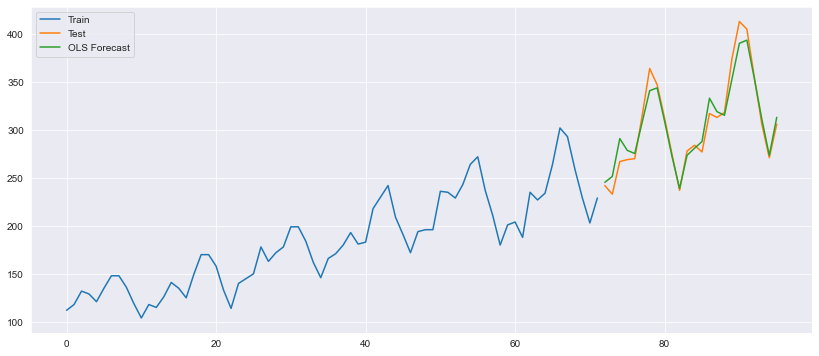

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(np.exp(pred_Mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
#Compare the results

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [ ]:
e = table_rmse.append(table_evaluation)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

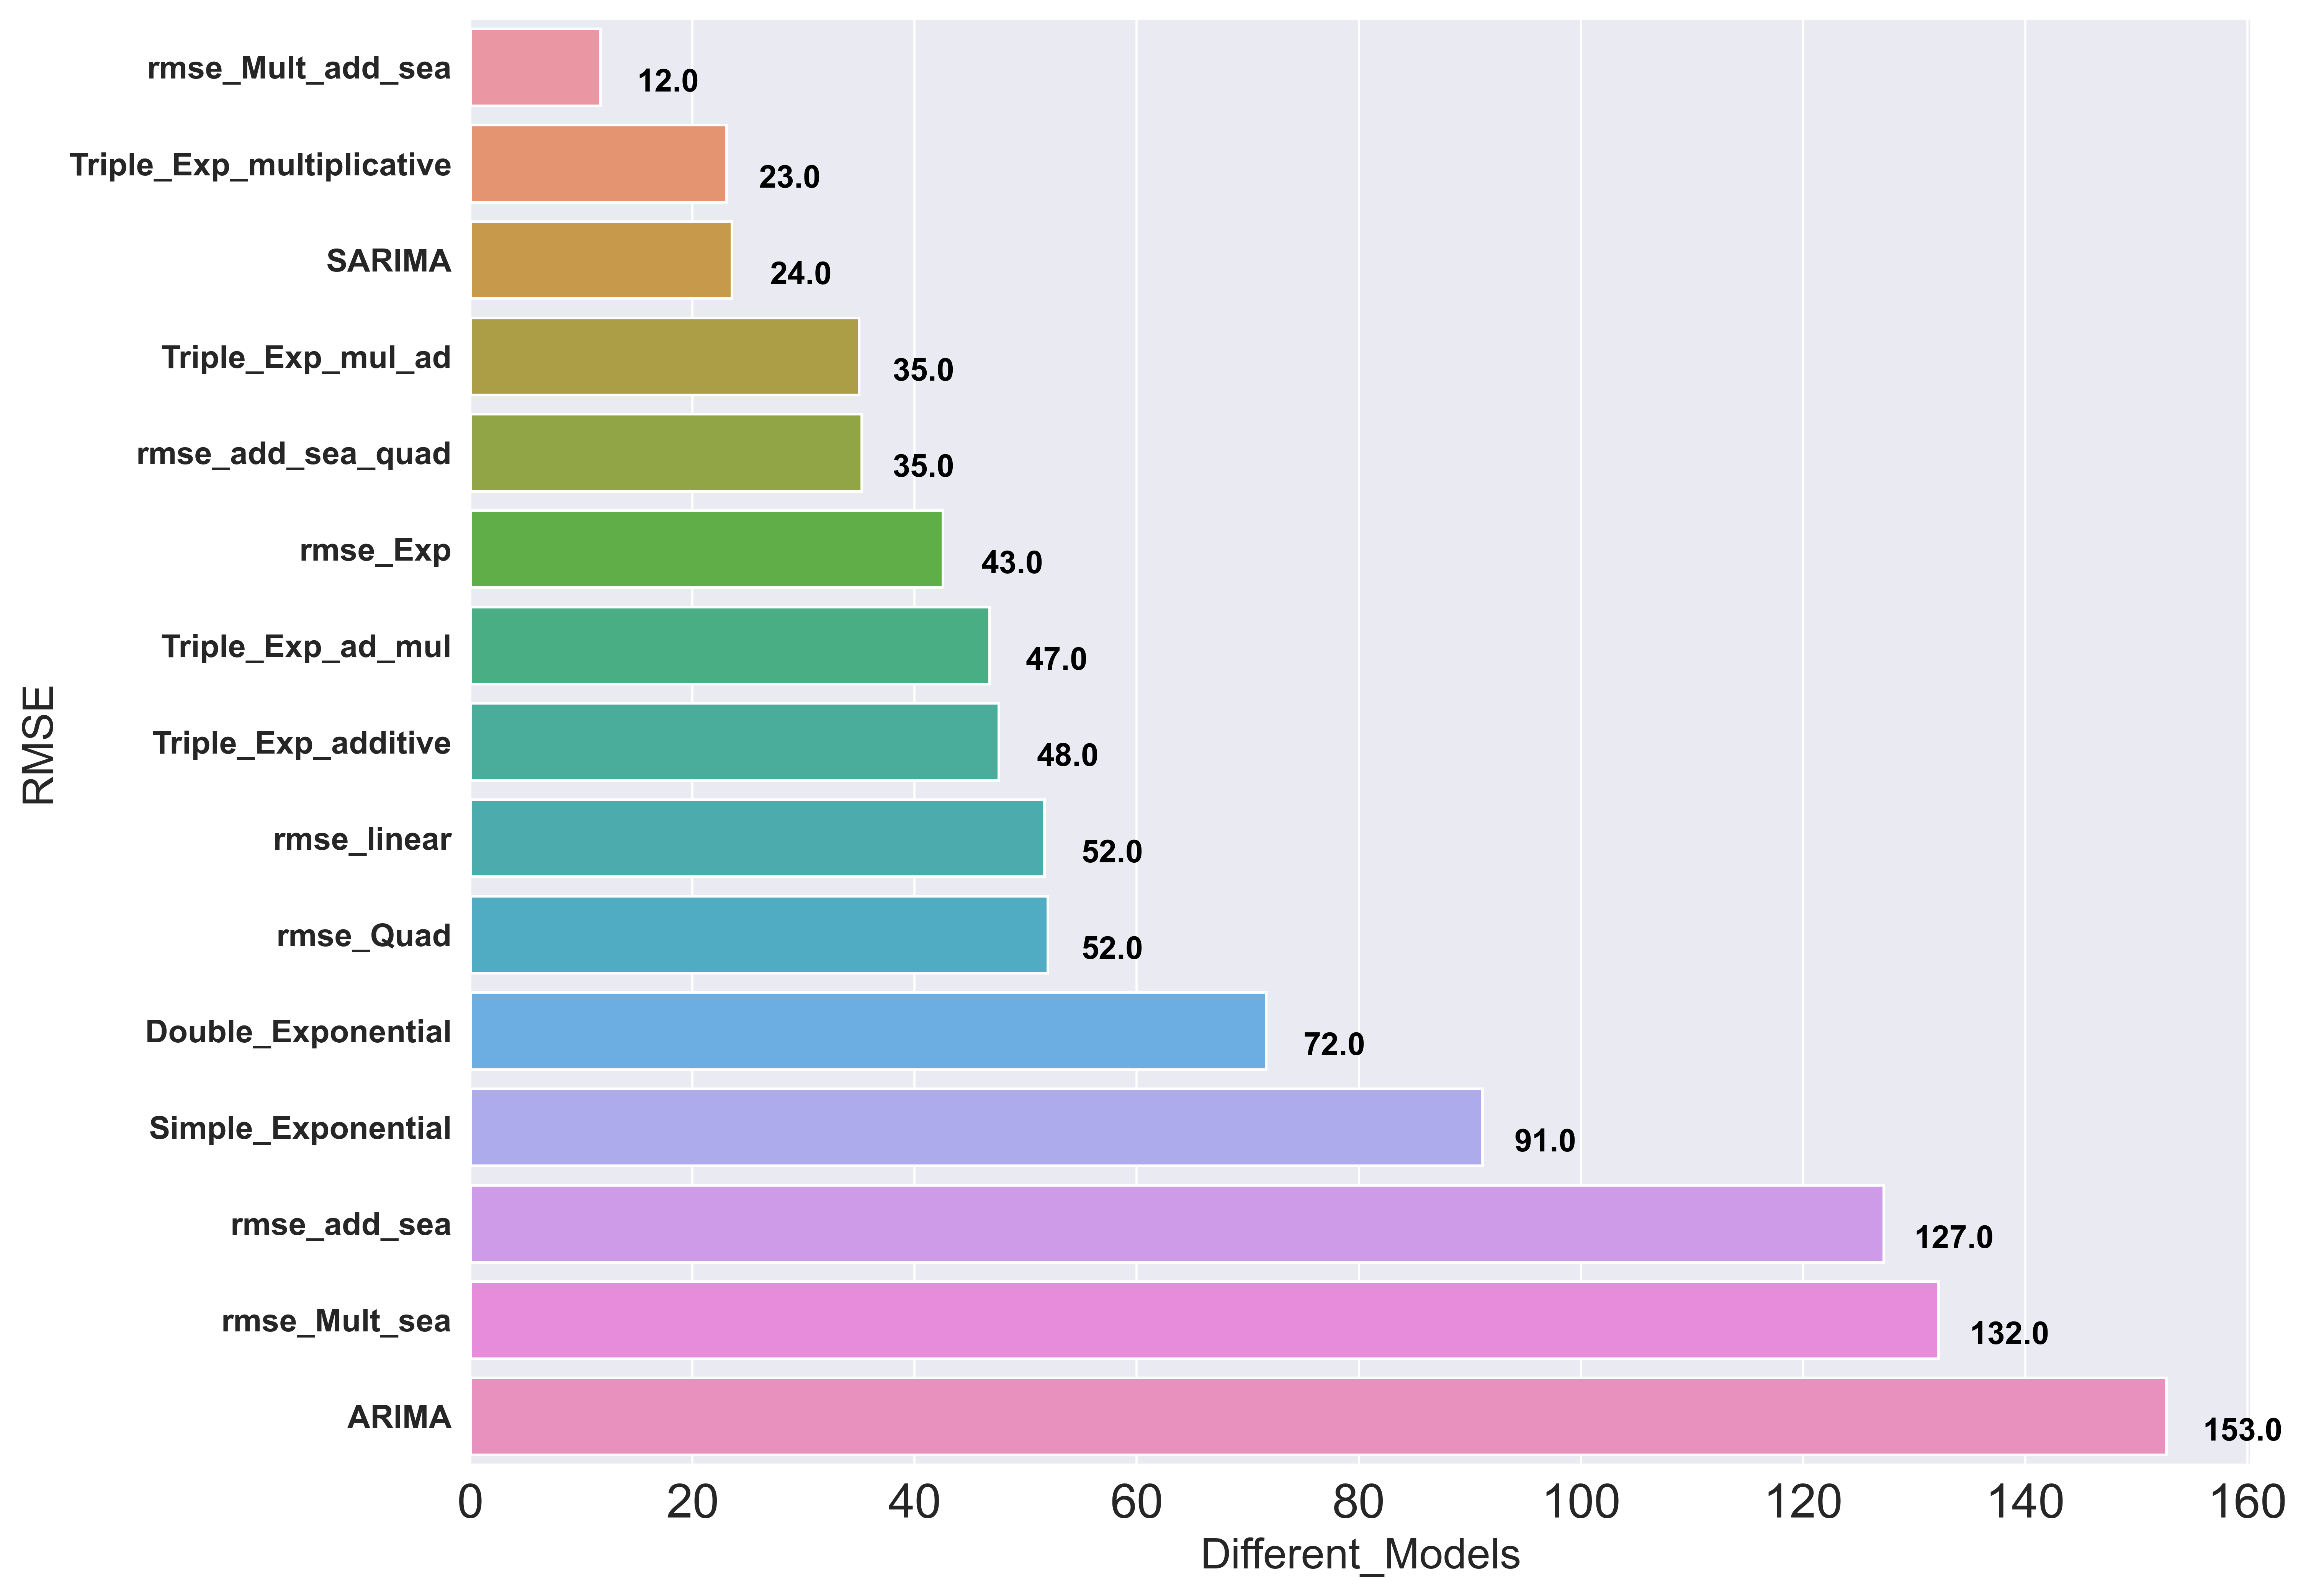

In [ ]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()

#### Conclusion:
## <p style="color:black;font-size:18;">Ordinary Least Sqaured with Multiplicative Additive Seasonality:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    

![image.png](attachment:image.png)